In [1]:
import numpy as np
import scipy as ci 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from IPython.display import display, HTML
from sklearn.externals import joblib

import seaborn as sns 
import random
import tables 
import pickle
import warnings
warnings.filterwarnings('once')

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

In [2]:
plt.figure()
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'font.size': 12})
plt.rc('axes', axisbelow=True)

<Figure size 432x288 with 0 Axes>

In [3]:
lifetime = 86400*365 # 1 year! 
fig_dir = '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/plots/ana-000-3-'
data_dir = '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/'
plt.rcParams.update({'font.size': 14})
plt.rc('axes', axisbelow=True)

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater


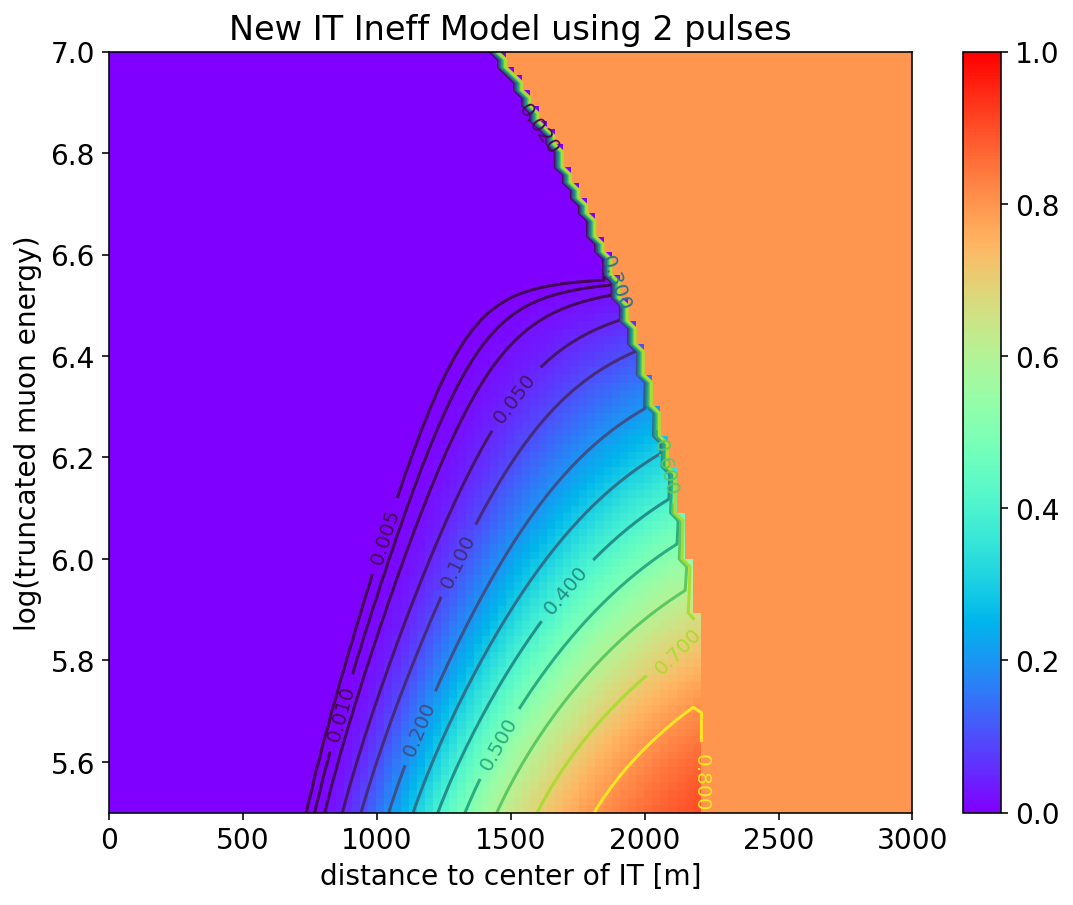

In [4]:
# OLD and NEW ineff model parameters 
params = np.loadtxt('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/IT_model_robust_2.txt')
# params = np.loadtxt('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/IT_model_robust_5.txt')

def ineff_model_new(dist,E): # E: log10 of energy!!! 
    
    a = params[0] * (E - params[1])**2 + params[2]
    b = params[3] * (E - params[4])**2 + params[5]
    
#     val = a * 1 / (1+np.exp(-(dist/2000-b)/c))
#     val = a * np.exp(-b/(dist/2000)**(4.7))
#     val = a * np.exp(-b/(dist/2000)**(5.3)) # 5 pulse robust
    val = a * np.exp(-b/(dist/2000)**(3.4)) # 2 pulse robust


    val[val < 1e-5] = 1e-5 # This is arbitrary! 

    # low stat cut 
    val[E > 5.47+2*np.sqrt(1 - ((dist-20)/2210)**2) ]=0.8
    val[dist > 2210] = 0.8
    return val

xt = np.linspace(0.001,3000,100) # dist 
yt = np.linspace(5.5,7,100)  # E 
xg,yg = np.meshgrid(xt,yt)
zg = ineff_model_new(xg,yg)

plt.figure(figsize=(9,7))
plt.pcolormesh(xg,yg,zg,cmap='rainbow',shading='flat')
plt.colorbar()
plt.clim(0,1) # colorbar limit
CS=plt.contour(xg,yg,zg,levels=[0.005,0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
plt.clabel(CS,inline=1,fmt='%1.3f',fontsize=10)
plt.xlabel('distance to center of IT [m]')
plt.ylabel('log(truncated muon energy)')
plt.xlim(0,3000)
plt.ylim(5.5,7)
plt.title('New IT Ineff Model using 2 pulses')
plt.show()

In [5]:
# with tables.open_file(data_dir+'data_h5/data_burn.h5','r') as f:
with tables.open_file(data_dir+'data_h5/data_burn_new.h5','r') as f: # 8 years
    nfile_data = [2831731.134,3081951.304,3158084.037,3155703.188,3082765.564]

    ineff_ = ineff_model_new(f.root.Dist_to_IT_center.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))

    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
    CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
    CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
    CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
    CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
    CUT_toposplit = f.root.TologicalCounterSplitCount.cols.value[:] == 1

#     CUT_ineff = ineff_ < ineffcut
    CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_toposplit
    
    ineff_data_burn = ineff_[CUT]
#     chi2_data_burn = f.root.Collection.cols.chi2[:][CUT]
    chi2_red_data_burn = f.root.Collection.cols.chi2_red[:][CUT]
#     chi2_new_data_burn = f.root.Collection.cols.chi2_new[:][CUT]
    chi2_red_new_data_burn = f.root.Collection.cols.chi2_red_new[:][CUT]
    PeakOverMedian_data_burn = f.root.Collection.cols.PeakOverMedian[:][CUT]
#     PeakOverMean_data_burn = f.root.Collection.cols.PeakOverMean[:][CUT]
    stoch_data_burn = (chi2_red_data_burn + (np.log10(PeakOverMedian_data_burn)/2))/np.sqrt(2)
#     stoch_new_data_burn = np.log10(chi2_red_new_data_burn)/8 + np.log10(PeakOverMedian_data_burn)
    
    zenith_data_burn = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_data_burn = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    len_dedx_data_burn = f.root.Collection.cols.len_dEdxVector[:][CUT]
    cascllh_data_burn = f.root.CascadeLlhVertexFitParams.cols.rlogL[:][CUT]
    NPE_data_burn = f.root.QTot.cols.value[:][CUT]
    Qtot_data_burn = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    N_dom_data_burn = f.root.Balloon.cols.N_Doms[:][CUT]
#     N_pulses_data_burn = f.root.Balloon.cols.N_Pulses[:][CUT]
    balloon_data_burn = f.root.Balloon.cols.InIceBalloonParameter[:][CUT]

    closest_d_data_burn = f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:][CUT]
    d_to_IC_center_data_burn = f.root.Dist_to_IC_center.cols.value[:][CUT]
    d_to_IT_center_data_burn = f.root.Dist_to_IT_center.cols.value[:][CUT]
    Ldir_data_burn = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:][CUT]

    IT_Npulse_data_burn = f.root.IT_veto_double.cols.num_Total_hits[:][CUT]
    Npulse_in_window_data_burn = f.root.IT_veto_double.cols.num_correlated_Total_hits_in_window[:][CUT]
    Npulse_off_window_data_burn = f.root.IT_veto_double.cols.num_correlated_Total_hits_off_window[:][CUT]

    passed_2_data_burn = (f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) # 1 if passed 
    vetoed_2_data_burn = (1 - f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) 
    
    # IT TW cleaning
#     passed_2_data_burn = (f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) # 1 if passed 
#     vetoed_2_data_burn = (1 - f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) 
    
    
    runid_data_burn = f.root.I3EventHeader.cols.Run[:][CUT]
    eventid_data_burn = f.root.I3EventHeader.cols.Event[:][CUT]

    weight_data_burn = lifetime/np.sum(nfile_data) * np.ones(len(zenith_data_burn))


/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater


[0.00000000e+00 1.05303062e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.10606124e-04
 3.15909187e-04 7.37121435e-04 1.57954593e-03 1.15833368e-03
 3.89621330e-03 8.00303273e-03 1.26363675e-02 2.46409166e-02
 5.08613790e-02 7.58182048e-02 1.36788678e-01 2.08500063e-01
 3.10328124e-01 4.32058464e-01 5.49997894e-01 7.01529000e-01
 7.96091150e-01 8.55482077e-01 8.70645718e-01 8.27471463e-01
 7.69765385e-01 6.91209300e-01 5.91697907e-01 5.03453940e-01
 3.82250116e-01 3.19700097e-01 2.49989470e-01 1.86912935e-01
 1.47108378e-01 1.03828819e-01 6.97106272e-02 4.25424371e-02
 2.89583421e-02 1.75856114e-02 1.06356093e-02 7.37121435e-03
 2.94848574e-03 1.47424287e-03 1.89545512e-03 1.05303062e-03
 4.21212249e-04 3.15909187e-04 2.10606124e-04 0.00000000e+00
 0.00000000e+00 1.05303062e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]


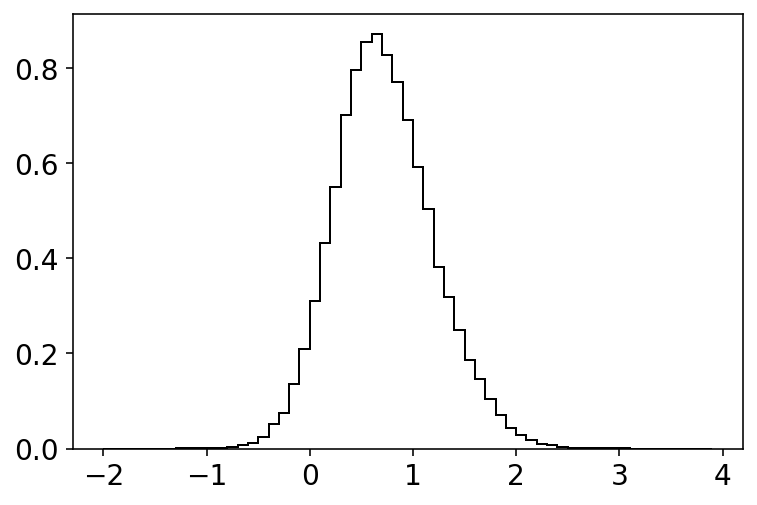

In [6]:
cut_data = (ineff_data_burn<0.01)
h__,b__,__=plt.hist(np.log10(chi2_red_new_data_burn[cut_data]),histtype='step',bins=np.arange(-2,4,0.1),color='black',density=True,label='data')
print(h__)

In [7]:
np.sum(passed_2_data_burn)

56007

In [8]:
# with tables.open_file(data_dir+'corsika_h5/corsika_combined.h5','r') as f:
with tables.open_file(data_dir+'corsika_h5/corsika.h5','r') as f: # All

    ineff_ = ineff_model_new(f.root.Dist_to_IT_center.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))

    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
    CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
    CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
    CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
    CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
    CUT_toposplit = f.root.TologicalCounterSplitCount.cols.value[:] == 1
    CUT_coincident = f.root.PolyplopiaInfo.cols.Multiplicity[:] == 1
    
    CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_toposplit & CUT_coincident
    
    ineff_corsika = ineff_[CUT]
    chi2_corsika = f.root.Collection.cols.chi2[:][CUT]
    chi2_red_corsika = f.root.Collection.cols.chi2_red[:][CUT]
    stoch_corsika = f.root.Collection.cols.stoch[:][CUT]
    chi2_new_corsika = f.root.Collection.cols.chi2_new[:][CUT]
    chi2_red_new_corsika = f.root.Collection.cols.chi2_red_new[:][CUT]
    PeakOverMedian_corsika = f.root.Collection.cols.PeakOverMedian[:][CUT]
    PeakOverMean_corsika = f.root.Collection.cols.PeakOverMean[:][CUT]

    zenith_corsika = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_corsika = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    len_dedx_corsika = f.root.Collection.cols.len_dEdxVector[:][CUT]
    cascllh_corsika = f.root.CascadeLlhVertexFitParams.cols.rlogL[:][CUT]
    NPE_corsika = f.root.QTot.cols.value[:][CUT]
    Qtot_corsika = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    N_dom_corsika = f.root.Balloon.cols.N_Doms[:][CUT]
    N_pulses_corsika = f.root.Balloon.cols.N_Pulses[:][CUT]
    balloon_corsika = f.root.Balloon.cols.InIceBalloonParameter[:][CUT]
    balloon_adjusted_corsika = f.root.Balloon.cols.InIceBalloonParameter_adjusted[:][CUT]
    in_ice_total_charge_corsika = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    in_ice_total_charge_reduced_corsika = f.root.Balloon.cols.InIceTotalCharge_reduced[:][CUT]
    ndirdoms_corsika = f.root.SplineMPEDirectHitsC.cols.n_dir_doms[:][CUT]
    ndirpulses_corsika = f.root.SplineMPEDirectHitsC.cols.n_dir_pulses[:][CUT]
    topocount_corsika = f.root.TologicalCounterSplitCount.cols.value[:][CUT]
    wimpcount_corsika = f.root.WIMPrecoTopoSplitSplitCount.cols.value[:][CUT]
    cv_ndoms_corsika = f.root.CVMultiplicity.cols.n_hit_doms[:][CUT]
    cv_npulses_corsika = f.root.CVMultiplicity.cols.n_pulses[:][CUT]
    
    closest_d_corsika = f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:][CUT]
    d_to_IC_center_corsika = f.root.Dist_to_IC_center.cols.value[:][CUT]
    d_to_IT_center_corsika = f.root.Dist_to_IT_center.cols.value[:][CUT]
    Ldir_corsika = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:][CUT]
#     coincident_corsika = f.root.MCPrimary_coincident.cols.value[:][CUT]
    coincident_corsika = f.root.PolyplopiaInfo.cols.Multiplicity[:][CUT]
    prim_e_corsika = f.root.PolyplopiaPrimary.cols.energy[:][CUT]
    
    E_bundle_corsika = f.root.Bundle.cols.MuonBundleEnergy_Ei[:][CUT]
    E_leading_muon_corsika = f.root.Bundle.cols.MostEnergeticMuonEnergy_i[:][CUT]
    singleness_corsika = f.root.Bundle.cols.Singleness_Ei[:][CUT]
    bsize_corsika = f.root.Bundle.cols.Size_Ei[:][CUT]
    xf_corsika = E_bundle_corsika/prim_e_corsika
    epsilon_corsika = E_leading_muon_corsika/prim_e_corsika
    E_shower_corsika = prim_e_corsika - E_bundle_corsika # surface shower
    
    runid_corsika = f.root.FileNumber.cols.value[:][CUT]
    eventid_corsika = f.root.FileNumber.cols.Event[:][CUT]
    
    A_corsika = f.root.PolyplopiaPrimary.cols.type[:][CUT]
    CUT_H = A_corsika == 2212
    CUT_He = A_corsika == 1000020040
    CUT_N= A_corsika == 1000070140
    CUT_Al = A_corsika == 1000130270
    CUT_Fe = A_corsika == 1000260560
    
    weight_corsika = f.root.Combined_Weight_H3a[:][CUT] * lifetime

    weight_corsika_H = np.sum(weight_corsika) * weight_corsika[CUT_H]/np.sum(weight_corsika[CUT_H])
    weight_corsika_He = np.sum(weight_corsika) * weight_corsika[CUT_He]/np.sum(weight_corsika[CUT_He])
    weight_corsika_N = np.sum(weight_corsika) * weight_corsika[CUT_N]/np.sum(weight_corsika[CUT_N])
    weight_corsika_Al = np.sum(weight_corsika) * weight_corsika[CUT_Al]/np.sum(weight_corsika[CUT_Al])
    weight_corsika_Fe = np.sum(weight_corsika) * weight_corsika[CUT_Fe]/np.sum(weight_corsika[CUT_Fe])

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater


In [9]:
# fraction of each element as a function of stochasticity?? 
def fraction(INEFF):
    plt.figure(figsize=(8,5))
    
    CUT = (ineff_corsika < INEFF)
#     CUT_H = C
    print(len(CUT))
    print(len(chi2_red_new_corsika))
    print(len(CUT_H))
    print(len(chi2_red_new_corsika))
    print(len(chi2_red_new_corsika[CUT]))
    print(len(CUT_H[CUT]))

    h_H,b=np.histogram(np.log10(chi2_red_new_corsika[CUT])[CUT_H[CUT]],bins=np.arange(-1,3,0.1),weights=(weight_corsika[CUT])[CUT_H[CUT]],density=1)
    h_He,b=np.histogram(np.log10(chi2_red_new_corsika[CUT])[CUT_He[CUT]],bins=np.arange(-1,3,0.1),weights=(weight_corsika[CUT])[CUT_He[CUT]],density=1)
    h_N,b=np.histogram(np.log10(chi2_red_new_corsika[CUT])[CUT_N[CUT]],bins=np.arange(-1,3,0.1),weights=(weight_corsika[CUT])[CUT_N[CUT]],density=1)
    h_Al,b=np.histogram(np.log10(chi2_red_new_corsika[CUT])[CUT_Al[CUT]],bins=np.arange(-1,3,0.1),weights=(weight_corsika[CUT])[CUT_Al[CUT]],density=1)
    h_Fe,b=np.histogram(np.log10(chi2_red_new_corsika[CUT])[CUT_Fe[CUT]],bins=np.arange(-1,3,0.1),weights=(weight_corsika[CUT])[CUT_Fe[CUT]],density=1)
    
    total = h_H + h_He + h_N + h_Al + h_Fe

    plt.plot((b[1:]+b[:-1])/2,h_H/total,'o-',label='H',color='red')
    plt.plot((b[1:]+b[:-1])/2,h_He/total,'o-',label='He',color='darkorange')
    plt.plot((b[1:]+b[:-1])/2,h_N/total,'o-',label='N',color='darkgreen')
    plt.plot((b[1:]+b[:-1])/2,h_Al/total,'o-',label='Al',color='steelblue')
    plt.plot((b[1:]+b[:-1])/2,h_Fe/total,'o-',label='Fe',color='m')

    plt.xlabel('log10 chi2_red_new')
    plt.legend(prop={'size': 10})
    plt.ylim(1e-3)
    plt.title('CORSIKA, normalized, fraction of events')
    plt.show()

2181925
2181925
2181925
2181925
1102206
1102206


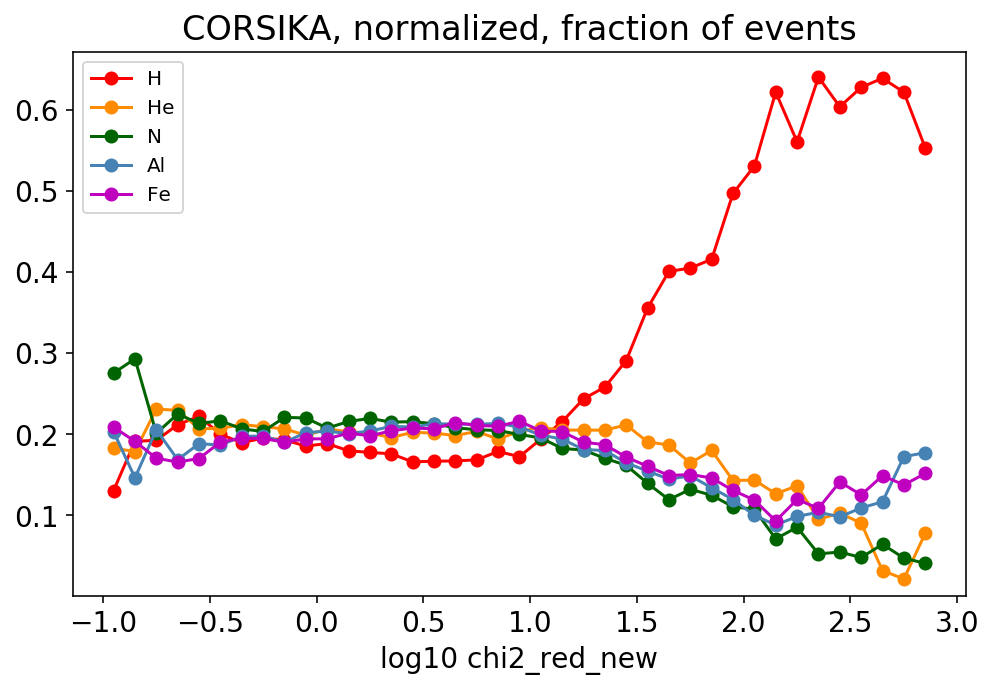

In [10]:
fraction(0.1)

In [11]:
# fraction of each element as a function of stochasticity?? 
def fraction(INEFF):
    plt.figure(figsize=(8,5))
    
    CUT = (ineff_corsika < INEFF)

    h_H,b=np.histogram(np.log10(E_shower_corsika[CUT])[CUT_H[CUT]],bins=np.arange(4,12,0.1),weights=(weight_corsika[CUT])[CUT_H[CUT]],density=1)
    h_He,b=np.histogram(np.log10(E_shower_corsika[CUT])[CUT_He[CUT]],bins=np.arange(4,12,0.1),weights=(weight_corsika[CUT])[CUT_He[CUT]],density=1)
    h_N,b=np.histogram(np.log10(E_shower_corsika[CUT])[CUT_N[CUT]],bins=np.arange(4,12,0.1),weights=(weight_corsika[CUT])[CUT_N[CUT]],density=1)
    h_Al,b=np.histogram(np.log10(E_shower_corsika[CUT])[CUT_Al[CUT]],bins=np.arange(4,12,0.1),weights=(weight_corsika[CUT])[CUT_Al[CUT]],density=1)
    h_Fe,b=np.histogram(np.log10(E_shower_corsika[CUT])[CUT_Fe[CUT]],bins=np.arange(4,12,0.1),weights=(weight_corsika[CUT])[CUT_Fe[CUT]],density=1)
    
    total = h_H + h_He + h_N + h_Al + h_Fe

    plt.plot((b[1:]+b[:-1])/2,h_H/total,'o-',label='H',color='red')
    plt.plot((b[1:]+b[:-1])/2,h_He/total,'o-',label='He',color='darkorange')
    plt.plot((b[1:]+b[:-1])/2,h_N/total,'o-',label='N',color='darkgreen')
    plt.plot((b[1:]+b[:-1])/2,h_Al/total,'o-',label='Al',color='steelblue')
    plt.plot((b[1:]+b[:-1])/2,h_Fe/total,'o-',label='Fe',color='m')

    plt.xlabel('log10 E_shower')
    plt.legend(prop={'size': 10})
    plt.ylim(1e-3)
    plt.title('CORSIKA, normalized, fraction of events')
    plt.show()

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


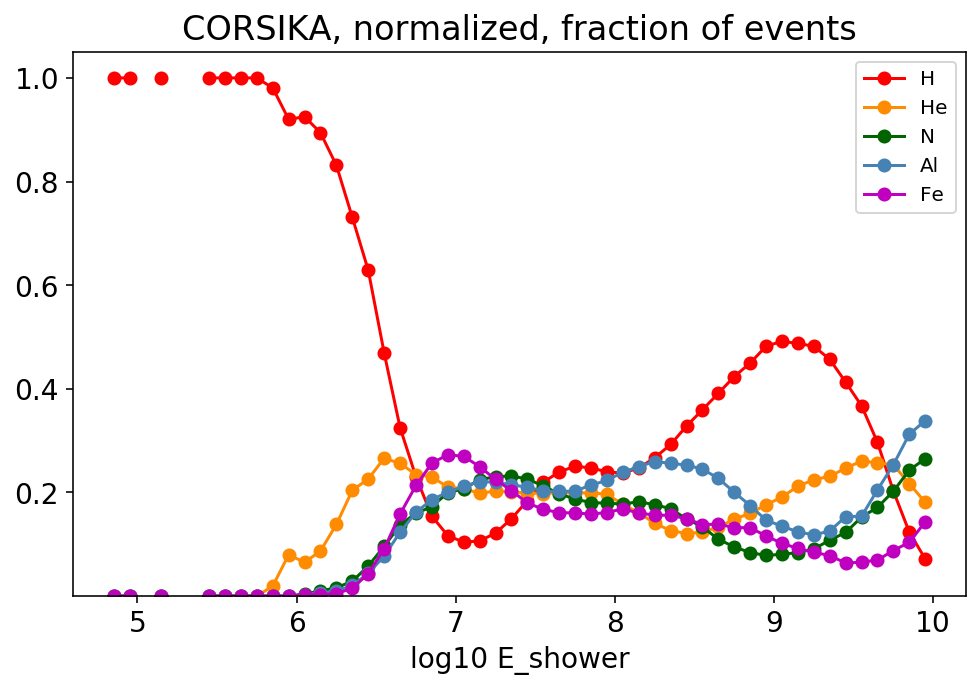

In [12]:
fraction(1)

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


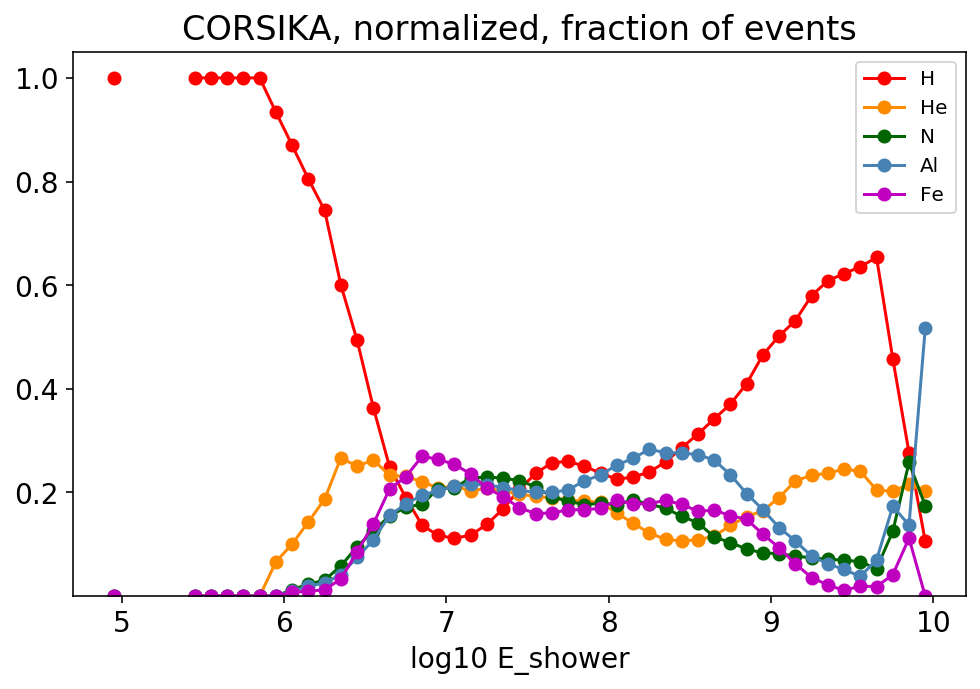

In [13]:
fraction(0.01)

In [14]:
# check bootstrap method using 1 bin. For presentation purpose! 

def compare(INEFF):
    def sumw2(b,weight,quantity):
        w_2 = []
        for i in range(0,len(b)-1):
            all_weight_in_bin = weight[(b[i]<quantity)&(quantity<b[i+1])]
            w_2.append(np.sum(all_weight_in_bin**2))
        return np.array(w_2)

    def sigma(x,y,sigx,sigy): # log10(x/y)
        return 1/np.log(10) * np.sqrt(sigx**2/x**2 + sigy**2/y**2)

    plt.figure(figsize=(6,4))
    
    CUT = (ineff_corsika < INEFF)
    h_H,b=np.histogram(np.log10(chi2_red_new_corsika[CUT])[CUT_H[CUT]],bins=np.linspace(-2,4,50),weights=(weight_corsika[CUT])[CUT_H[CUT]],density=1)
    h_He,b=np.histogram(np.log10(chi2_red_new_corsika[CUT])[CUT_He[CUT]],bins=np.linspace(-2,4,50),weights=(weight_corsika[CUT])[CUT_He[CUT]],density=1)
    h_N,b=np.histogram(np.log10(chi2_red_new_corsika[CUT])[CUT_N[CUT]],bins=np.linspace(-2,4,50),weights=(weight_corsika[CUT])[CUT_N[CUT]],density=1)      
    h_Al,b=np.histogram(np.log10(chi2_red_new_corsika[CUT])[CUT_Al[CUT]],bins=np.linspace(-2,4,50),weights=(weight_corsika[CUT])[CUT_Al[CUT]],density=1)
    h_Fe,b=np.histogram(np.log10(chi2_red_new_corsika[CUT])[CUT_Fe[CUT]],bins=np.linspace(-2,4,50),weights=(weight_corsika[CUT])[CUT_Fe[CUT]],density=1)
    
    total = h_H + h_He + h_N + h_Al + h_Fe
    
    sigma_H = np.sqrt(sumw2(b,(weight_corsika[CUT])[CUT_H[CUT]],np.log10(chi2_red_new_corsika[CUT])[CUT_H[CUT]]))
    sigma_Fe = np.sqrt(sumw2(b,(weight_corsika[CUT])[CUT_Fe[CUT]],np.log10(chi2_red_new_corsika[CUT])[CUT_Fe[CUT]]))
#     print(h_H,h_Fe,sigma_H,sigma_Fe)
    plt.plot((b[1:]+b[:-1])/2,h_H/total,'o-',label='H',color='red')
#     plt.plot((b[1:]+b[:-1])/2,h_He/total,'o-',label='He',color='darkorange')
#     plt.plot((b[1:]+b[:-1])/2,h_N/total,'o-',label='N',color='darkgreen')
#     plt.plot((b[1:]+b[:-1])/2,h_Al/total,'o-',label='Al',color='steelblue')
#     plt.plot((b[1:]+b[:-1])/2,h_Fe/total,'o-',label='Fe',color='m')

#     plt.plot((b[1:]+b[:-1])/2,np.log10(h_H/h_Fe),'o-',label='H/Fe',color='blue')
#     plt.errorbar((b[1:]+b[:-1])/2,h_H,yerr=sigma_H,fmt='o',label='H',color='red')
#     plt.errorbar((b[1:]+b[:-1])/2,h_Fe,yerr=sigma_Fe,fmt='o',label='Fe',color='red')

#     plt.plot((b[1:]+b[:-1])/2,np.log10(h_H/h_Fe),yerr=sigma(h_H,h_Fe,sigma_H,sigma_Fe),color='blue')
    
    plt.xlabel('log10 chi2_red_new')
    plt.legend(prop={'size': 10})
#     plt.ylim(1e-3)
    plt.xlim(-2,4)
    plt.title('CORSIKA, normalized, fraction of events')
    plt.show()
    
    def sigma(x,y): # log10(x/y)
        return weight_data_burn[0]/np.log(10) * np.sqrt(1/x+1/y)

    cut = (ineff_data_burn<INEFF)

#     chi2_red_new_data_burn = chi2_red_new_data_burn_[cut]
#     passed_2_data_burn = passed_2_data_burn_[cut]
#     vetoed_2_data_burn = vetoed_2_data_burn_[cut]
#     weight_data_burn = weight_data_burn[cut]

    Nbins = 50
    Bins = np.linspace(-2,4,Nbins) # FIXME: Careful about the range

    # make some plots

    plt.figure(figsize=(12,4))
    plt.subplot(121)
    h_veto,b_,p_ = plt.hist(np.log10(chi2_red_new_data_burn[cut])[vetoed_2_data_burn[cut]],bins=Bins,histtype='step',weights=weight_data_burn[cut][vetoed_2_data_burn[cut]],label='data burn, vetoed',log=True)
    h_pass,b_,p_ = plt.hist(np.log10(chi2_red_new_data_burn[cut])[passed_2_data_burn[cut]],bins=Bins,histtype='step',weights=weight_data_burn[cut][passed_2_data_burn[cut]],label='data burn, passed',log=True)
    plt.xlabel('log10 chi2_red_new')
#             plt.axvline(chi2control,color='green',label='validation cut')
#         plt.axvline(chi2cut,color='purple',label='stochasticity cut')
    plt.legend(prop={'size':9})

    h_veto,b_ = np.histogram(np.log10(chi2_red_new_data_burn[cut])[vetoed_2_data_burn[cut]],bins=Bins,weights=weight_data_burn[cut][vetoed_2_data_burn[cut]]) 
    h_pass,b_ = np.histogram(np.log10(chi2_red_new_data_burn[cut])[passed_2_data_burn[cut]],bins=Bins,weights=weight_data_burn[cut][passed_2_data_burn[cut]]) 

    b_ = (b_[1:]+b_[:-1])/2
    b_=b_[h_pass>0]
    h_veto=h_veto[h_pass>0]
    h_pass=h_pass[h_pass>0]
    pv_ratio = h_pass/h_veto
    sig_vp = sigma(h_pass,h_veto)

    def f(x,a,b):
        return a*x + b
    # fitting using bootstrapped sample 

    plt.subplot(122)
    t = np.arange(-1,4,0.01)
#     print(np.log10(pv_ratio))
#     print(np.min(np.isfinite(np.log10(pv_ratio))),np.max(np.isfinite(np.log10(pv_ratio))))
#         plt.plot(t,f(t,*popt_fulls[0]),'--',color='steelblue',alpha=1,label='fit')
#     plt.errorbar(b_,np.log10(pv_ratio),fmt='.',yerr=sig_vp,capsize=3,color='black')
    plt.errorbar(b_,pv_ratio,fmt='.',yerr=sig_vp,capsize=3,color='black')
    
#         plt.axvline(chi2cut,color='purple',label='stochasticity cut')
#     plt.ylim(np.min(np.log10(pv_ratio)[np.isfinite(np.log10(pv_ratio))]),np.max(np.log10(pv_ratio)[np.isfinite(np.log10(pv_ratio))]))
    plt.ylim(-0.05,0.6)
    plt.xlabel('log10 chi2_red_new')
    plt.ylabel('log10 passed/vetoed')
#         plt.legend(prop={'size':9})
    plt.show()


/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


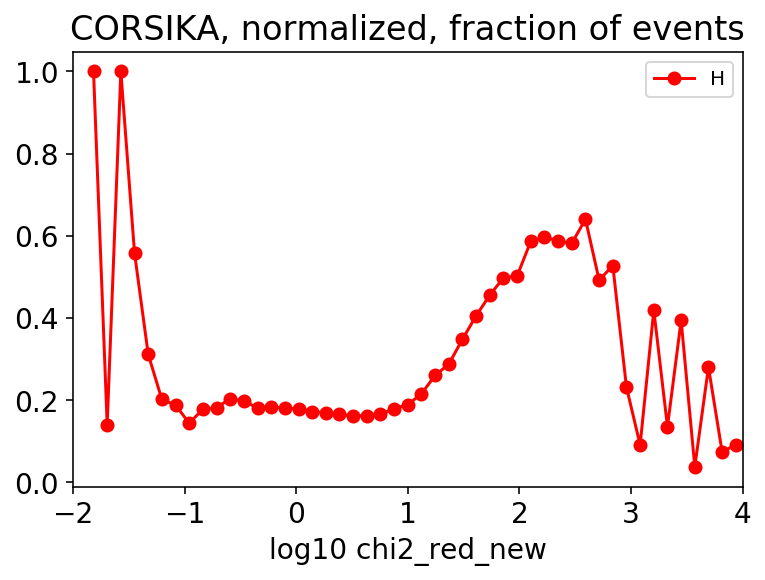

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/Users/yang/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3370: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


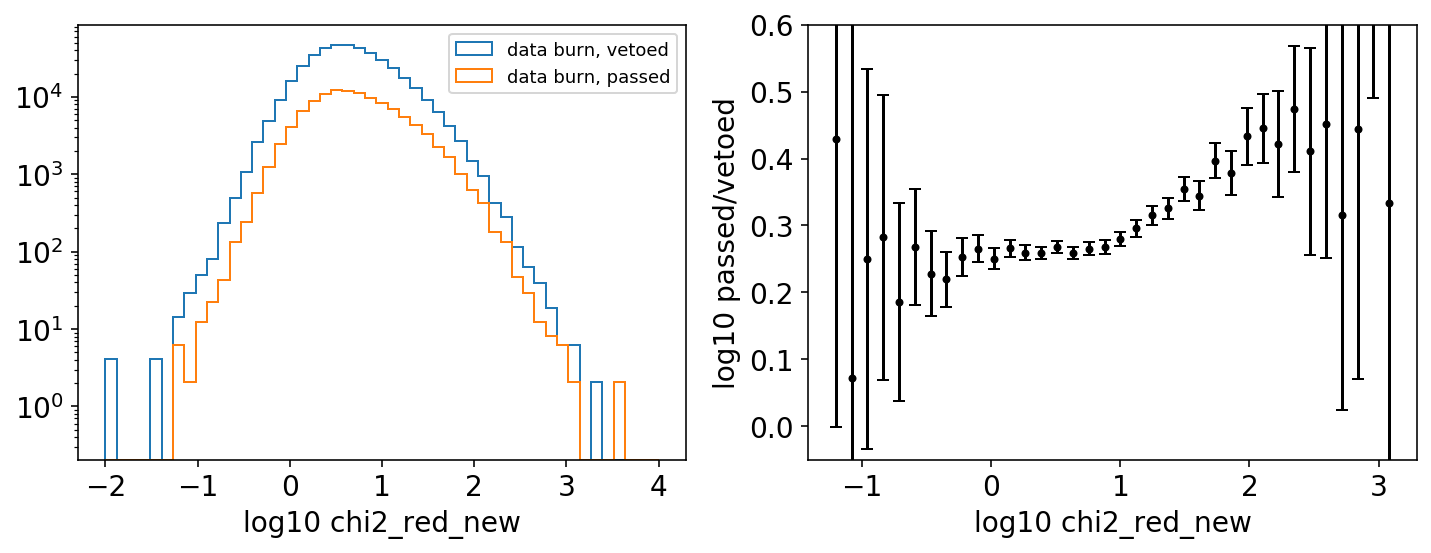

In [15]:
compare(1)

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


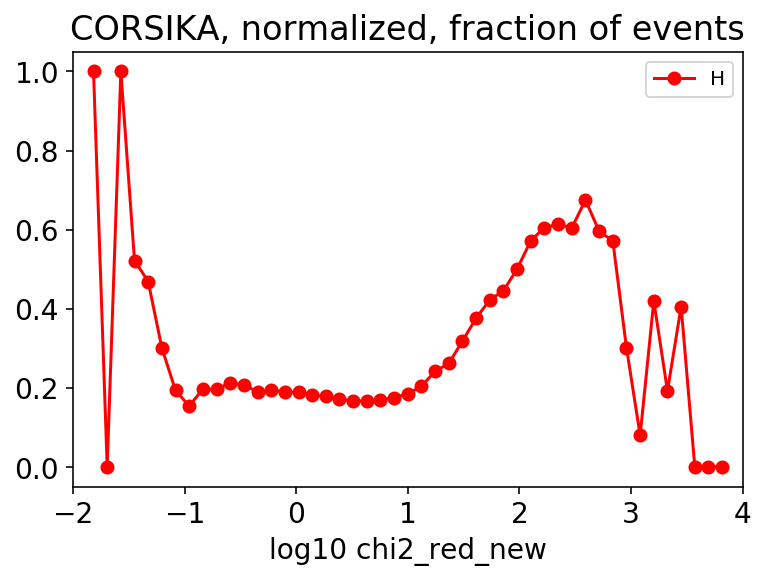

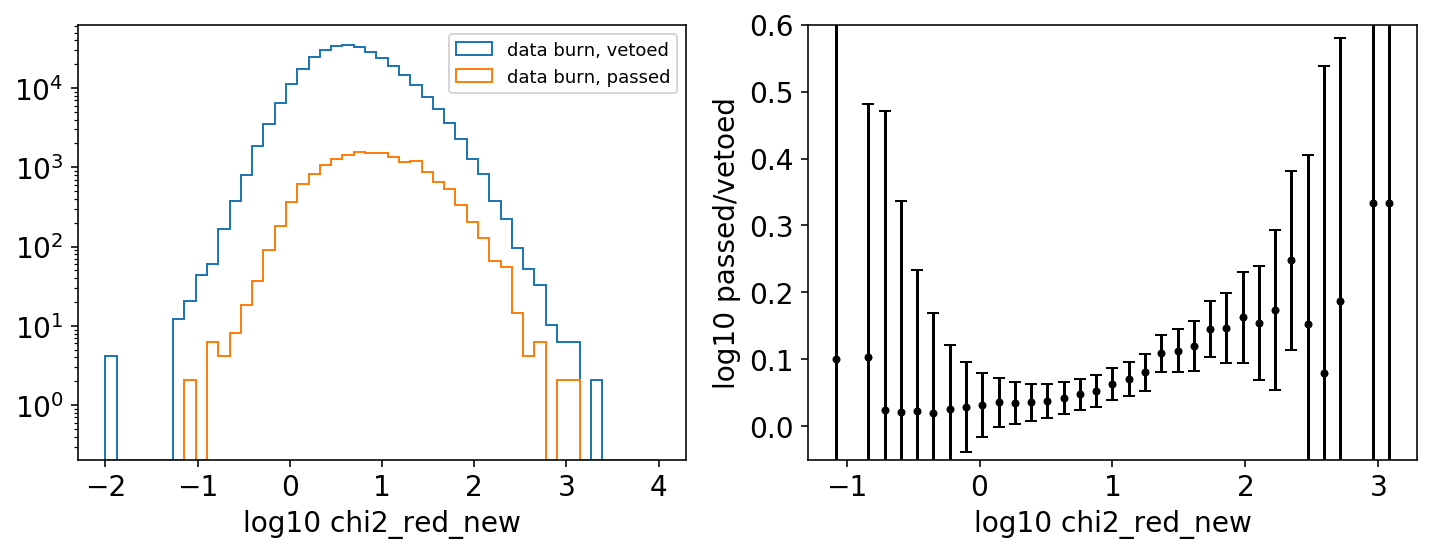

In [16]:
compare(0.2)

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


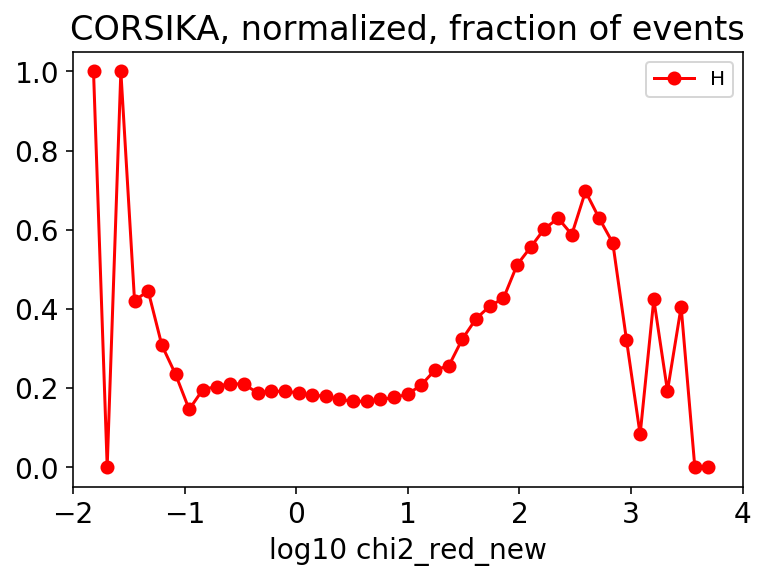

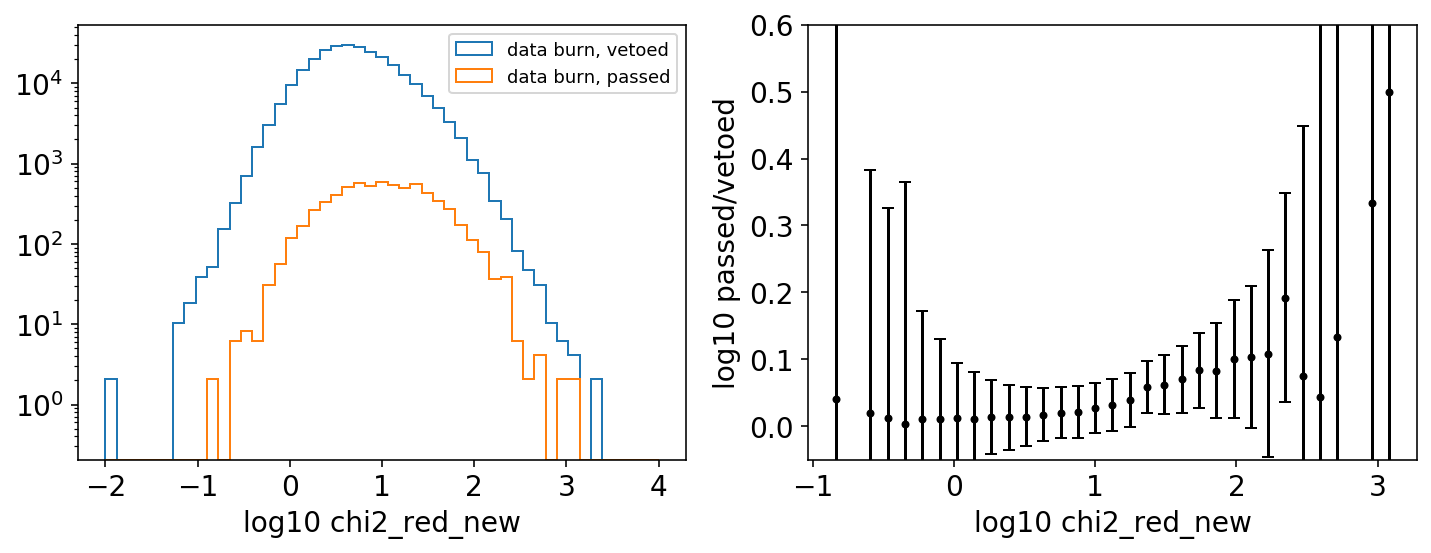

In [17]:
compare(0.1)

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


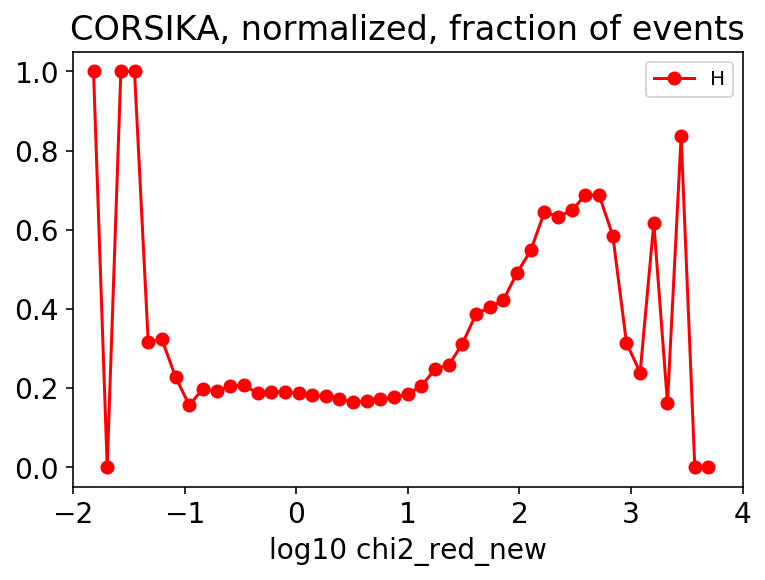

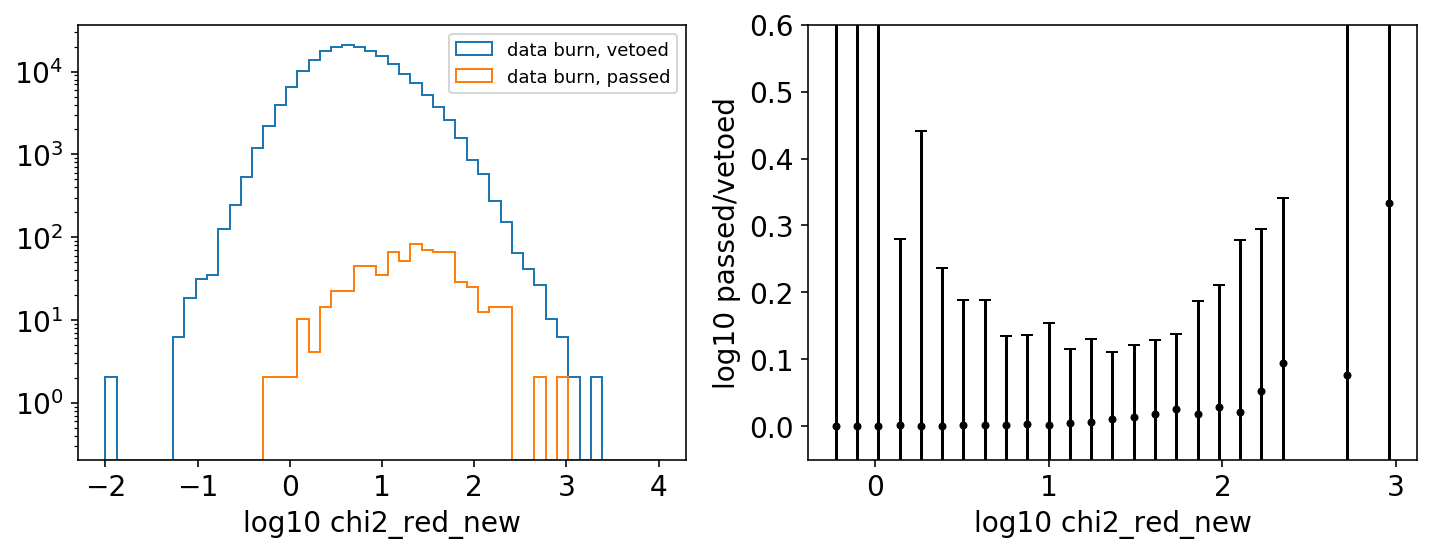

In [18]:
compare(0.01)

# try template fitting

In [19]:
def fitting(INEFF):
    plt.figure(figsize=(8,5))
    bins = np.arange(-2,4,0.1)
    bundle_threshold = 0.2
    single_threshold = 0.8
    
    cut_corsika = (ineff_corsika<INEFF)
    cut_data = (ineff_data_burn<INEFF)
    h_bundle,b,_=plt.hist(np.log10(chi2_red_new_corsika[cut_corsika])[singleness_corsika[cut_corsika]<bundle_threshold],histtype='step',weights=weight_corsika[cut_corsika][singleness_corsika[cut_corsika]<bundle_threshold],bins=bins,density=True,label='bundle',color='dodgerblue')
    h_single,b,_=plt.hist(np.log10(chi2_red_new_corsika[cut_corsika])[singleness_corsika[cut_corsika]>single_threshold],histtype='step',weights=weight_corsika[cut_corsika][singleness_corsika[cut_corsika]>single_threshold],bins=bins,density=True,label='single',color='darkorange')
    h_data,b,_=plt.hist(np.log10(chi2_red_new_data_burn[cut_data]),histtype='step',bins=bins,color='black',density=True,label='data')
    plt.legend()
    plt.xlim(-2,4)
    plt.xlabel('log10 chi2_red_new')
    plt.show()
    
    bs = (b[1:]+b[:-1])/2
    def llh(y):
        exp = y*h_bundle + (1-y)*h_single
        obs = h_data
        cut = (exp>0) & (obs>0)
    #     print(exp,obs)
        exp = exp[cut]
        obs = obs[cut]

        lnL = np.log(exp)*obs - exp - (obs*np.log(obs) - obs)
        return - np.sum(lnL)

    t = np.arange(0,1,0.001)
    ls = []
    for i in t:
        ls.append(llh(i))
    ls = np.array(ls)
#     plt.plot(t,ls)
#     plt.xlabel('fraction of bundle distribution')
#     plt.ylabel('-lnL')

    print(t[ls==np.min(ls)])
    y_best = t[ls==np.min(ls)][0]

    plt.figure(figsize=(8,5))
    plt.plot(bs,h_bundle*y_best,'--',label='bundle',color='dodgerblue')
    plt.plot(bs,h_single*(1-y_best),'--',label='single',color='darkorange')
    plt.plot(bs,h_data,'x',label='data',color='black')
    plt.plot(bs,h_bundle*y_best+h_single*(1-y_best),'o-',label='fit',color='green')
    plt.xlabel('log10 chi2_red_new')
    plt.legend(loc='upper right')
    plt.xlim(-2,4)
    plt.show()

    plt.figure(figsize=(8,5))
    plt.plot(bs,h_bundle*y_best,'--',label='bundle',color='dodgerblue')
    plt.plot(bs,h_single*(1-y_best),'--',label='single',color='darkorange')
    plt.plot(bs,h_data,'x',label='data',color='black')
    plt.plot(bs,h_bundle*y_best+h_single*(1-y_best),label='fit',color='green')
    plt.xlabel('log10 chi2_red_new')
    plt.xlim(-2,4)
    plt.ylim(1e-5,)
    plt.yscale('log')
    plt.legend(loc='upper right')
    
    def sigma(x,y): # x/y
        return weight_data_burn[0]*x/y * np.sqrt(1/x + 1/y)

    def sigma_log10(x,y): # log10(x/y)
        return weight_data_burn[0]/np.log(10) * np.sqrt(1/x + 1/y)

#     plt.figure(figsize=(8,5))
#     h_veto,b_,p_ = plt.hist(np.log10(chi2_red_new_data_burn[cut_data])[vetoed_2_data_burn[cut_data]],bins=bins,histtype='step',weights=weight_data_burn[cut_data][vetoed_2_data_burn[cut_data]],label='data burn, vetoed',log=True)
#     h_pass,b_,p_ = plt.hist(np.log10(chi2_red_new_data_burn[cut_data])[passed_2_data_burn[cut_data]],bins=bins,histtype='step',weights=weight_data_burn[cut_data][passed_2_data_burn[cut_data]],label='data burn, passed',log=True)
#     plt.xlabel('log10 chi2_red_new')
#     plt.legend(prop={'size':9})

    h_tot,b_ = np.histogram(np.log10(chi2_red_new_data_burn[cut_data]),bins=bins,weights=weight_data_burn[cut_data]) 
    h_veto,b_ = np.histogram(np.log10(chi2_red_new_data_burn[cut_data])[vetoed_2_data_burn[cut_data]],bins=bins,weights=weight_data_burn[cut_data][vetoed_2_data_burn[cut_data]]) 
    h_pass,b_ = np.histogram(np.log10(chi2_red_new_data_burn[cut_data])[passed_2_data_burn[cut_data]],bins=bins,weights=weight_data_burn[cut_data][passed_2_data_burn[cut_data]]) 

    b_ = (b_[1:]+b_[:-1])/2
    b_=b_[h_pass>0]
    h_veto=h_veto[h_pass>0]
    h_tot=h_tot[h_pass>0]
    h_pass=h_pass[h_pass>0]
    pass_ratio = h_pass/h_tot
    veto_ratio = h_veto/h_tot
    sig_pass = sigma(h_pass,h_tot)
    sig_pass_log10 = sigma_log10(h_pass,h_tot)
    sig_veto = sigma(h_veto,h_tot)
    pv_ratio = h_pass/h_veto
    sig_vp = sigma(h_pass,h_veto)
    sig_vp_log10 = sigma_log10(h_pass,h_veto)
    
    plt.figure(figsize=(8,5))
    t = np.arange(-2,4,0.01)
    plt.errorbar(b_,pass_ratio,fmt='.',yerr=sig_pass,capsize=3,color='black')
    plt.xlim(-2,4)
    plt.ylim(-0.05,0.4)
    plt.xlabel('log10 chi2_red_new')
    plt.ylabel('passing fraction')

    plt.figure(figsize=(8,5))
    t = np.arange(-2,4,0.01)
    plt.errorbar(b_,np.log10(pass_ratio),fmt='.',yerr=sig_pass_log10,capsize=3,color='black')
    plt.xlim(-2,4)
    plt.ylim(np.min(np.log10(pass_ratio)[np.isfinite(np.log10(pass_ratio))]),np.max(np.log10(pass_ratio)[np.isfinite(np.log10(pass_ratio))]))
    plt.xlabel('log10 chi2_red_new')
    plt.ylabel('log10 passing fraction')

#     plt.figure(figsize=(8,5))
#     t = np.arange(-2,4,0.01)
#     plt.errorbar(b_,pv_ratio,fmt='.',yerr=sig_vp,capsize=3,color='black')
#     plt.xlim(-2,4)
#     plt.ylim(-0.05,0.6)
#     plt.xlabel('log10 chi2_red_new')
#     plt.ylabel('passed/vetoed')
    
#     plt.figure(figsize=(8,5))
#     t = np.arange(-2,4,0.01)
#     plt.errorbar(b_,np.log10(pv_ratio),fmt='.',yerr=sig_vp_log10,capsize=3,color='black')
#     plt.xlim(-2,4)
#     plt.ylim(np.min(np.log10(pv_ratio)[np.isfinite(np.log10(pv_ratio))]),np.max(np.log10(pv_ratio)[np.isfinite(np.log10(pv_ratio))]))
#     plt.xlabel('log10 chi2_red_new')
#     plt.ylabel('log10 passed/vetoed')
    
    plt.show()

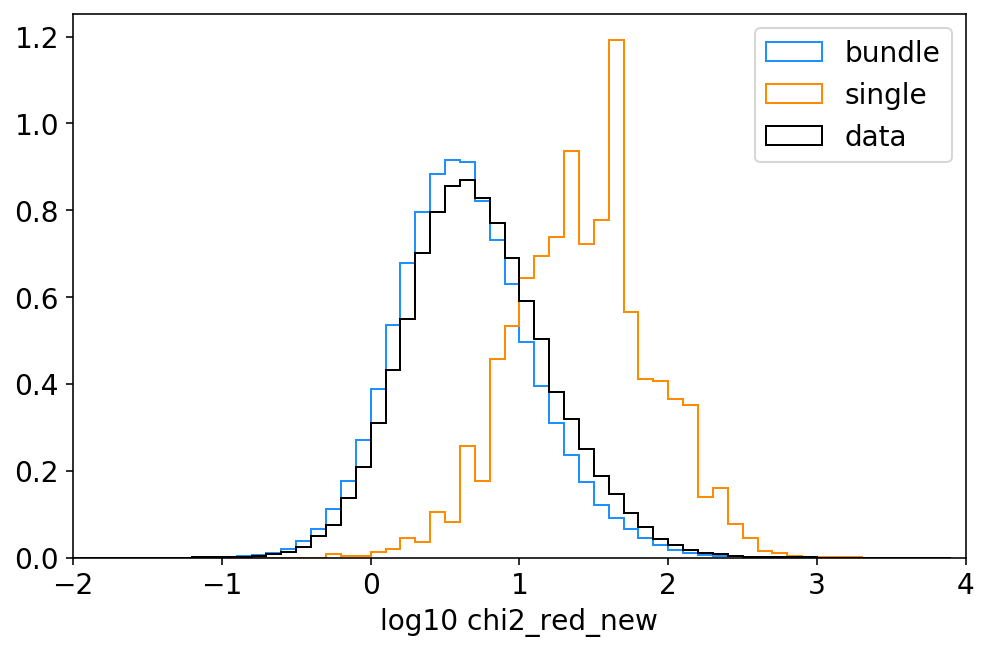

[0.928]


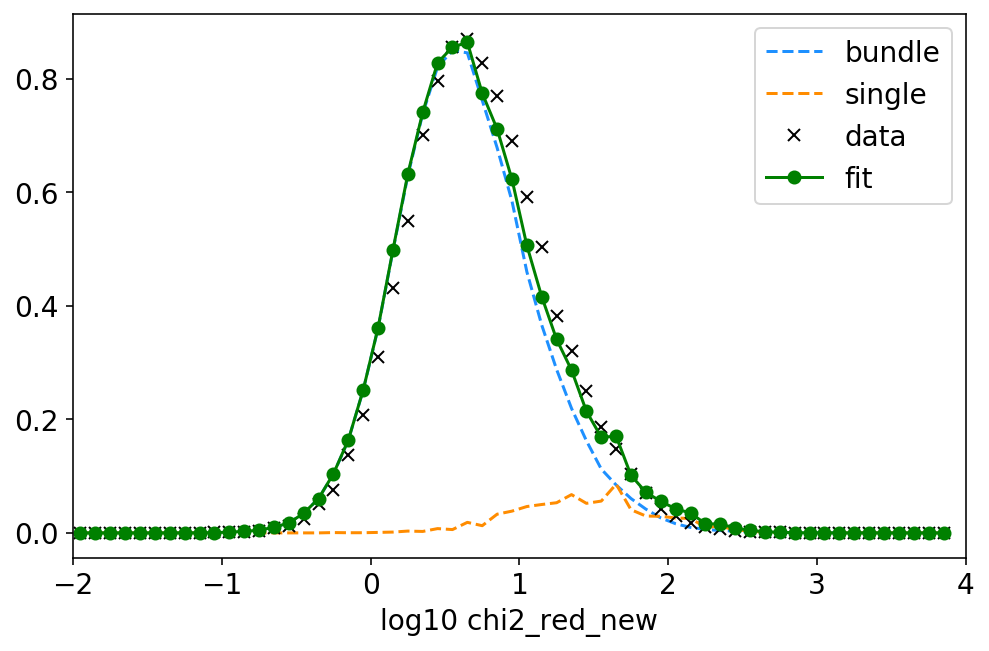

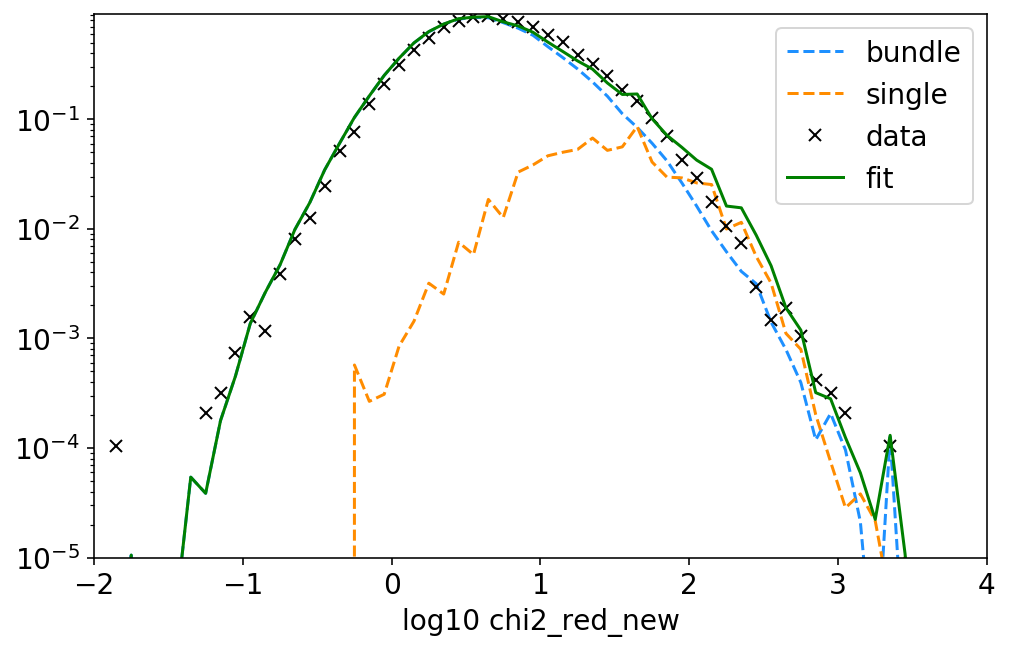

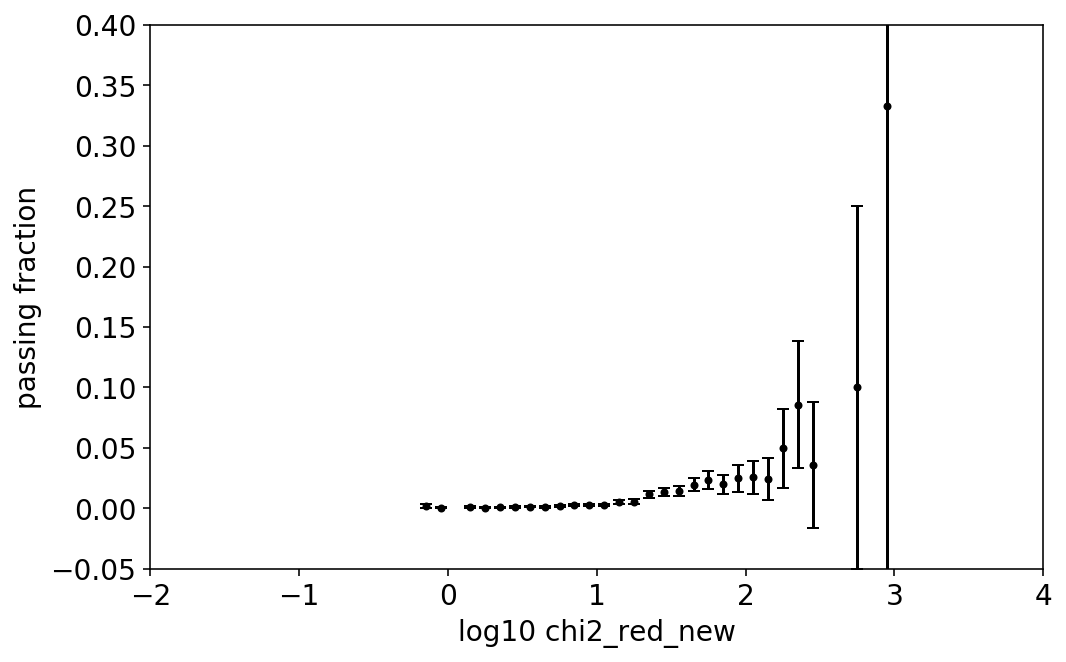

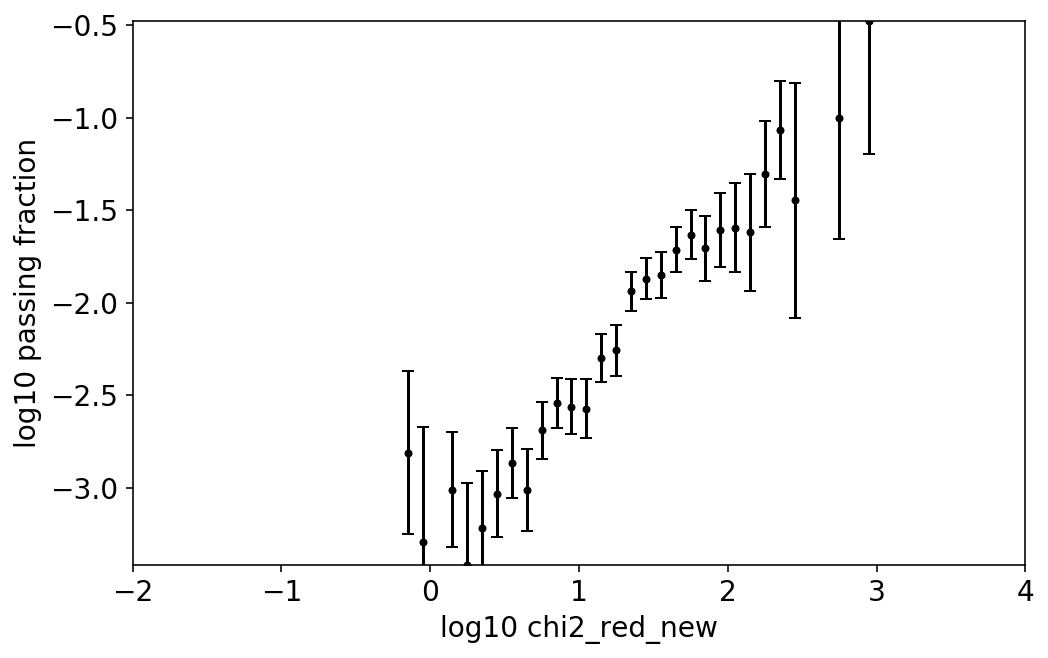

In [20]:
fitting(0.01)

# find xF

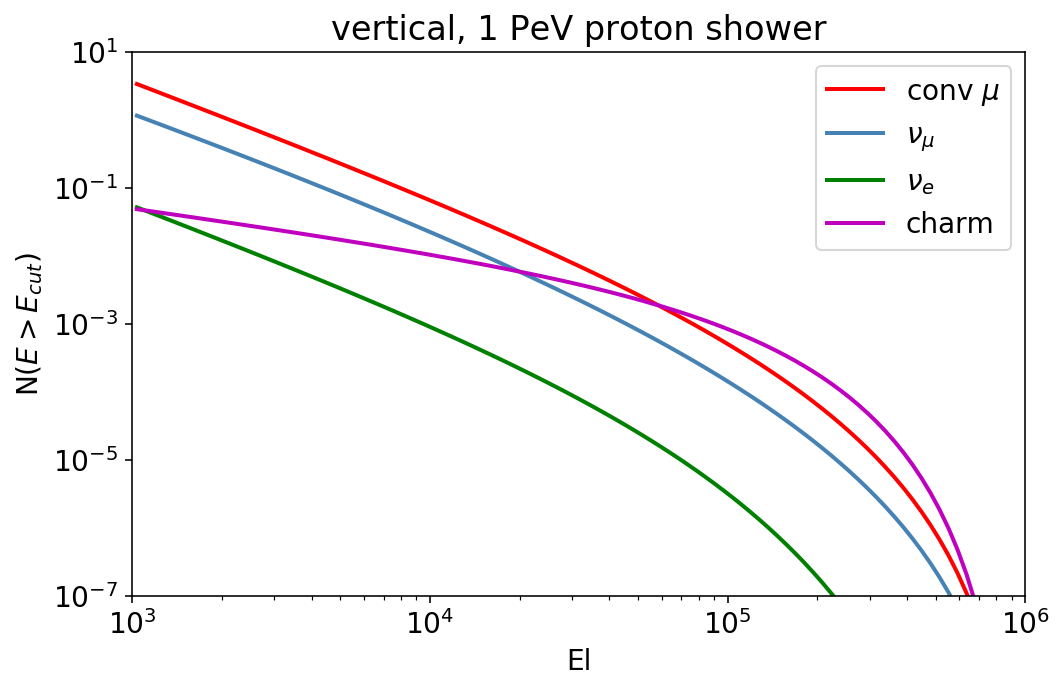

In [21]:
# testing elbert formula
from scipy import integrate as integrate

# def Elbert(Xf,A,cos_zenith,El): # X: x, A, cos_zenith
#     Kl = 49.5
#     p1 = 0.625
#     p2 = 4.94
#     p3 = 0.58
#     return Kl*A/(El*cos_zenith) * Xf**(-p1) * (1-Xf**p3)**p2


def Elbert(A,E,cos_zenith,El,ptype): # A, primary, cos(zenith), Ecut
    if ptype == 'elbert mu':
        Kl = 14.5
        p1 = 0.757
        p2 = 5.25
        p3 = 1
    elif ptype == 'conventional mu':
        Kl = 49.5
        p1 = 0.625
        p2 = 4.94
        p3 = 0.58
    elif ptype == 'numu':
        Kl = 79.9
        p1 = 0.463
        p2 = 4.37
        p3 = 0.316
    elif ptype == 'nue':
        Kl = 0.805
        p1 = 0.619
        p2 = 9.78
        p3 = 0.651
    elif ptype == 'charm':
        Kl = 0.000780
        p1 = 0.604
        p2 = 7.34
        p3 = 0.767
        return Kl*A * (A*El/E)**(-p1) * (1-(A*El/E)**p3)**p2
        
    return Kl*A/(El*cos_zenith) * (A*El/E)**(-p1) * (1-(A*El/E)**p3)**p2

e = np.logspace(3,6,100)
es = []
ns_conv = []
ns_elbert=[]
ns_numu=[]
ns_nue=[]
ns_charm=[]

for i in range(0,len(e)-1):
    es = np.append(es, np.sqrt(e[i]*e[i+1]))
    ns_conv = np.append(ns_conv, Elbert(1,1e6,1,e[i],'conventional mu'))
    ns_elbert = np.append(ns_elbert, Elbert(1,1e6,1,e[i],'elbert mu'))
    ns_numu = np.append(ns_numu, Elbert(1,1e6,1,e[i],'numu'))
    ns_nue = np.append(ns_nue, Elbert(1,1e6,1,e[i],'nue'))
    ns_charm = np.append(ns_charm, Elbert(1,1e6,1,e[i],'charm'))

plt.figure(figsize=(8,5))
plt.loglog(es,ns_conv,label=r'conv $\mu$',color='r',lw=2)
# plt.loglog(es,ns_elbert,label=r'elbert $\mu$',color='darkorange',lw=2)
plt.loglog(es,ns_numu,label=r'$\nu_\mu$',color='steelblue',lw=2)
plt.loglog(es,ns_nue,label=r'$\nu_e$',color='green',lw=2)
plt.loglog(es,ns_charm,label='charm',color='m',lw=2)

plt.legend()
plt.xlim(1e3,1e6)
plt.ylim(1e-7,10)
plt.xlabel('threshold E_{cut} [GeV]')
plt.ylabel(r'N($E>E_{cut}$)')
plt.xlabel('El')
plt.title('vertical, 1 PeV proton shower')
plt.show()

In [22]:
from scipy import integrate as integrate

def Elbert(A,cos_zenith,Xf): # X: x, A, cos_zenith
    Kl = 49.5
    p1 = 0.625
    p2 = 4.94
    p3 = 0.58
    return Kl*A/(1000*cos_zenith) * Xf**(-p1) * (1-Xf**p3)**p2

# x = np.linspace(0,1,1000)
x = np.logspace(-5,0,1000)
xs = []
ns = []
for i in range(0,len(x)-1):
    result = integrate.nquad(Elbert,[[1,56],[1e-10,1]],args=(x[i],))[0]
    xs.append((x[i]+x[i+1])/2)
    ns.append(result)
xs = np.array(xs)
ns = np.array(ns)
ns = ns/np.sum(ns)

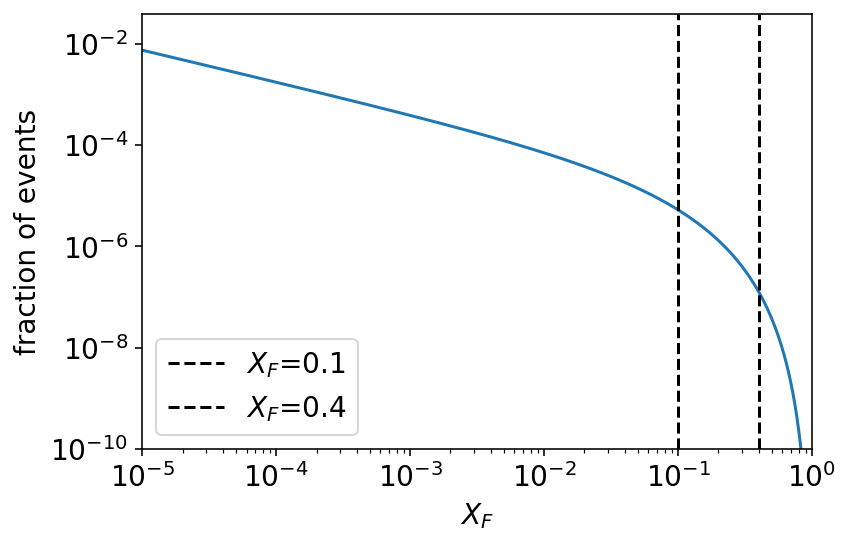

In [23]:
plt.loglog(xs,ns,'-')
plt.xlabel(r'$X_F$')
plt.ylabel('fraction of events')
plt.xlim(1e-5,1)
plt.ylim(1e-10,)
plt.axvline(0.1,ls='--',color='black',label=r'$X_F$=0.1')
plt.axvline(0.4,ls='--',color='black',label=r'$X_F$=0.4')
plt.legend()
plt.semilogy()
plt.show()

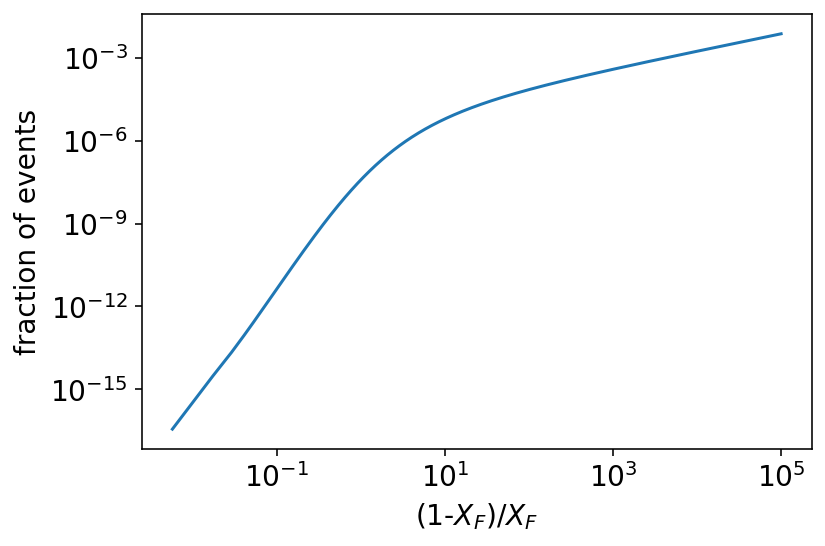

In [24]:
plt.loglog((1-xs)/xs,ns,'-')
plt.xlabel(r'(1-$X_F$)/$X_F$')
plt.ylabel('fraction of events')
# plt.xlim(1e-6,1)
# plt.ylim(1e-10,)
# plt.axvline(0.4,ls='--',color='black',label=r'$X_F$=0.4')
# plt.legend()
plt.semilogy()
plt.show()

In [25]:
print(np.sum(xs*ns)/np.sum(xs))

4.114407701708275e-06


In [26]:
P_bundle = 1-1e-3
xavg = np.sum(xs*ns)/np.sum(xs)

def pveto(x):
#     xavg = 0.08
    tmp = P_bundle * (1-x)/x * xavg/(1-xavg)
    return tmp/np.sum(tmp)

P_single = np.sum(pveto(xs)*ns)

In [27]:
print(P_bundle,P_single)

0.999 0.004526148886952237


# calculate Pveto

In [28]:
# try on INEFF < 0.01 
INEFF = 0.01

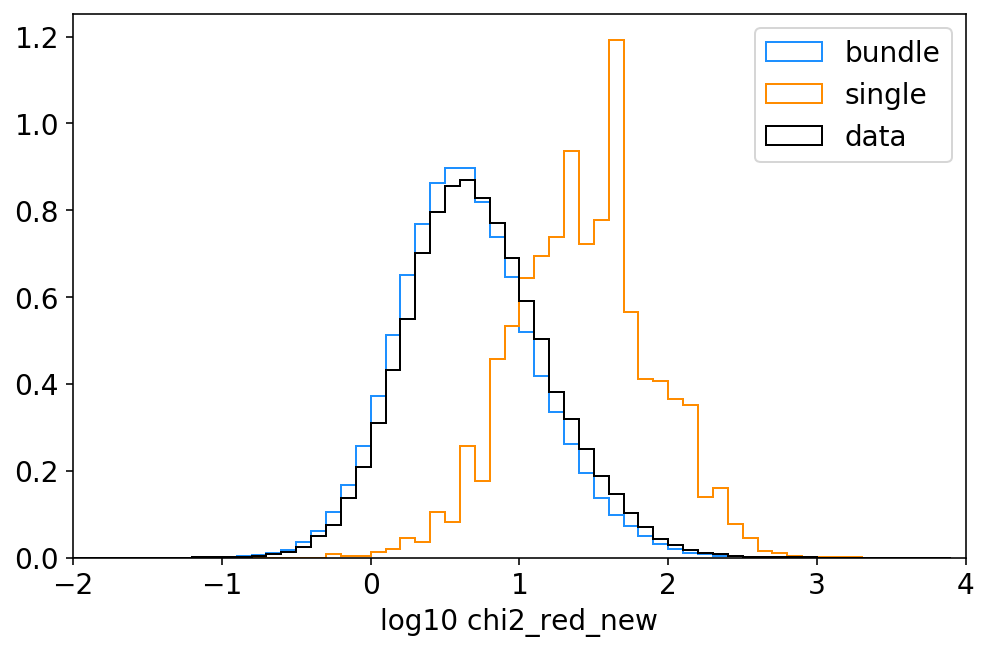

In [29]:
plt.figure(figsize=(8,5))
bins = np.arange(-2,4,0.1)
bundle_threshold = 0.8 # bundle: singleness < bundle_threshold
single_threshold = 0.8 # single: singleness > single_threshold

cut_corsika = (ineff_corsika<INEFF)
cut_data = (ineff_data_burn<INEFF)
h_bundle,b,_=plt.hist(np.log10(chi2_red_new_corsika[cut_corsika])[singleness_corsika[cut_corsika]<bundle_threshold],histtype='step',weights=weight_corsika[cut_corsika][singleness_corsika[cut_corsika]<bundle_threshold],bins=bins,density=True,label='bundle',color='dodgerblue')
h_single,b,_=plt.hist(np.log10(chi2_red_new_corsika[cut_corsika])[singleness_corsika[cut_corsika]>single_threshold],histtype='step',weights=weight_corsika[cut_corsika][singleness_corsika[cut_corsika]>single_threshold],bins=bins,density=True,label='single',color='darkorange')
h_data,b,_=plt.hist(np.log10(chi2_red_new_data_burn[cut_data]),histtype='step',bins=bins,color='black',density=True,label='data')
plt.legend()
plt.xlim(-2,4)
# plt.semilogy()
plt.xlabel('log10 chi2_red_new')
plt.show()

In [30]:
h_data

array([0.00000000e+00, 1.05303062e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.10606124e-04,
       3.15909187e-04, 7.37121435e-04, 1.57954593e-03, 1.15833368e-03,
       3.89621330e-03, 8.00303273e-03, 1.26363675e-02, 2.46409166e-02,
       5.08613790e-02, 7.58182048e-02, 1.36788678e-01, 2.08500063e-01,
       3.10328124e-01, 4.32058464e-01, 5.49997894e-01, 7.01529000e-01,
       7.96091150e-01, 8.55482077e-01, 8.70645718e-01, 8.27471463e-01,
       7.69765385e-01, 6.91209300e-01, 5.91697907e-01, 5.03453940e-01,
       3.82250116e-01, 3.19700097e-01, 2.49989470e-01, 1.86912935e-01,
       1.47108378e-01, 1.03828819e-01, 6.97106272e-02, 4.25424371e-02,
       2.89583421e-02, 1.75856114e-02, 1.06356093e-02, 7.37121435e-03,
       2.94848574e-03, 1.47424287e-03, 1.89545512e-03, 1.05303062e-03,
       4.21212249e-04, 3.15909187e-04, 2.10606124e-04, 0.00000000e+00,
       0.00000000e+00, 1.05303062e-04, 0.00000000e+00, 0.00000000e+00,
      

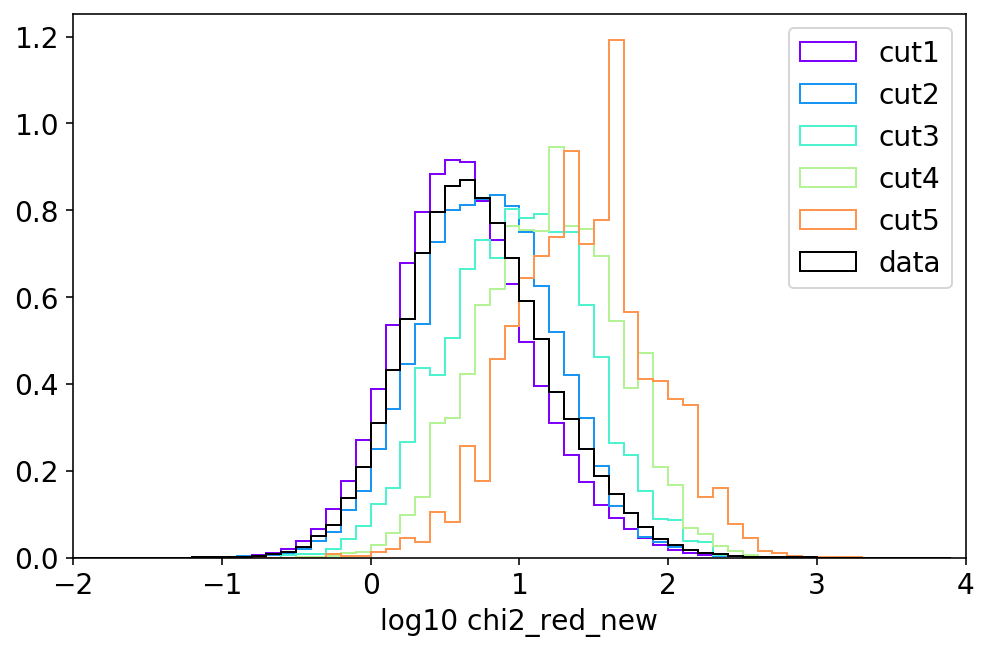

In [31]:
plt.figure(figsize=(8,5))
bins = np.arange(-2,4,0.1)

cut_corsika = (ineff_corsika<INEFF)
cut_data = (ineff_data_burn<INEFF)
cut_1 = (singleness_corsika[cut_corsika]>0.0)&(singleness_corsika[cut_corsika]<0.2)
cut_2 = (singleness_corsika[cut_corsika]>0.2)&(singleness_corsika[cut_corsika]<0.4)
cut_3 = (singleness_corsika[cut_corsika]>0.4)&(singleness_corsika[cut_corsika]<0.6)
cut_4 = (singleness_corsika[cut_corsika]>0.6)&(singleness_corsika[cut_corsika]<0.8)
cut_5 = (singleness_corsika[cut_corsika]>0.8)&(singleness_corsika[cut_corsika]<1.0)

mycmap=matplotlib.cm.get_cmap('rainbow')
h_1,b,_=plt.hist(np.log10(chi2_red_new_corsika[cut_corsika])[cut_1],histtype='step',weights=weight_corsika[cut_corsika][cut_1],bins=bins,density=True,label='cut1',color=mycmap(0.0))
h_2,b,_=plt.hist(np.log10(chi2_red_new_corsika[cut_corsika])[cut_2],histtype='step',weights=weight_corsika[cut_corsika][cut_2],bins=bins,density=True,label='cut2',color=mycmap(0.2))
h_3,b,_=plt.hist(np.log10(chi2_red_new_corsika[cut_corsika])[cut_3],histtype='step',weights=weight_corsika[cut_corsika][cut_3],bins=bins,density=True,label='cut3',color=mycmap(0.4))
h_4,b,_=plt.hist(np.log10(chi2_red_new_corsika[cut_corsika])[cut_4],histtype='step',weights=weight_corsika[cut_corsika][cut_4],bins=bins,density=True,label='cut4',color=mycmap(0.6))
h_5,b,_=plt.hist(np.log10(chi2_red_new_corsika[cut_corsika])[cut_5],histtype='step',weights=weight_corsika[cut_corsika][cut_5],bins=bins,density=True,label='cut5',color=mycmap(0.8))

h_data,b,_=plt.hist(np.log10(chi2_red_new_data_burn[cut_data]),histtype='step',bins=bins,color='black',density=True,label='data')
plt.legend()
plt.xlim(-2,4)
# plt.semilogy()
plt.xlabel('log10 chi2_red_new')
plt.show()

In [32]:
# KDE for single muons
from scipy import stats

bs = (b[1:]+b[:-1])/2

var_bundle = np.log10(chi2_red_new_corsika[cut_corsika])[singleness_corsika[cut_corsika]<bundle_threshold]
varweight_bundle = weight_corsika[cut_corsika][singleness_corsika[cut_corsika]<bundle_threshold]
var_single = np.log10(chi2_red_new_corsika[cut_corsika])[singleness_corsika[cut_corsika]>single_threshold]
varweight_single = weight_corsika[cut_corsika][singleness_corsika[cut_corsika]>single_threshold]
var_data = np.log10(chi2_red_new_data_burn[cut_data])

bandwidth='scott'
kernel_single = stats.gaussian_kde(var_single,weights=varweight_single,bw_method=bandwidth)
kde_single = kernel_single(bs)

kernel_bundle = stats.gaussian_kde(var_bundle,weights=varweight_bundle,bw_method=bandwidth)
kde_bundle = kernel_bundle(bs)

kernel_data = stats.gaussian_kde(var_data,bw_method=bandwidth)
kde_data = kernel_data(bs)

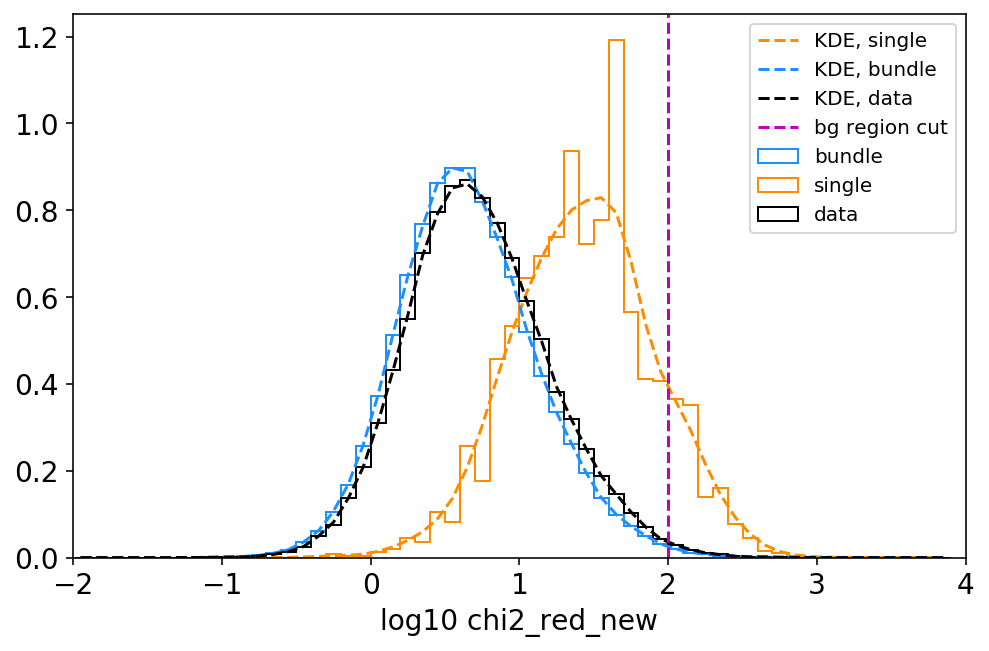

In [33]:
plt.figure(figsize=(8,5))

plt.hist(np.log10(chi2_red_new_corsika[cut_corsika])[singleness_corsika[cut_corsika]<bundle_threshold],histtype='step',weights=weight_corsika[cut_corsika][singleness_corsika[cut_corsika]<bundle_threshold],bins=bins,density=True,label='bundle',color='dodgerblue')
plt.hist(np.log10(chi2_red_new_corsika[cut_corsika])[singleness_corsika[cut_corsika]>single_threshold],histtype='step',weights=weight_corsika[cut_corsika][singleness_corsika[cut_corsika]>single_threshold],bins=bins,density=True,label='single',color='darkorange')
plt.hist(np.log10(chi2_red_new_data_burn[cut_data]),histtype='step',bins=bins,color='black',density=True,label='data')
plt.plot(bs,kde_single,label='KDE, single',ls='--',color='darkorange')
plt.plot(bs,kde_bundle,label='KDE, bundle',ls='--',color='dodgerblue')
plt.plot(bs,kde_data,label='KDE, data',ls='--',color='black')
plt.axvline(2,color='m',ls='--',label='bg region cut')

plt.legend(prop={'size':10})
plt.xlim(-2,4)
# plt.semilogy()
plt.xlabel('log10 chi2_red_new')
plt.show()

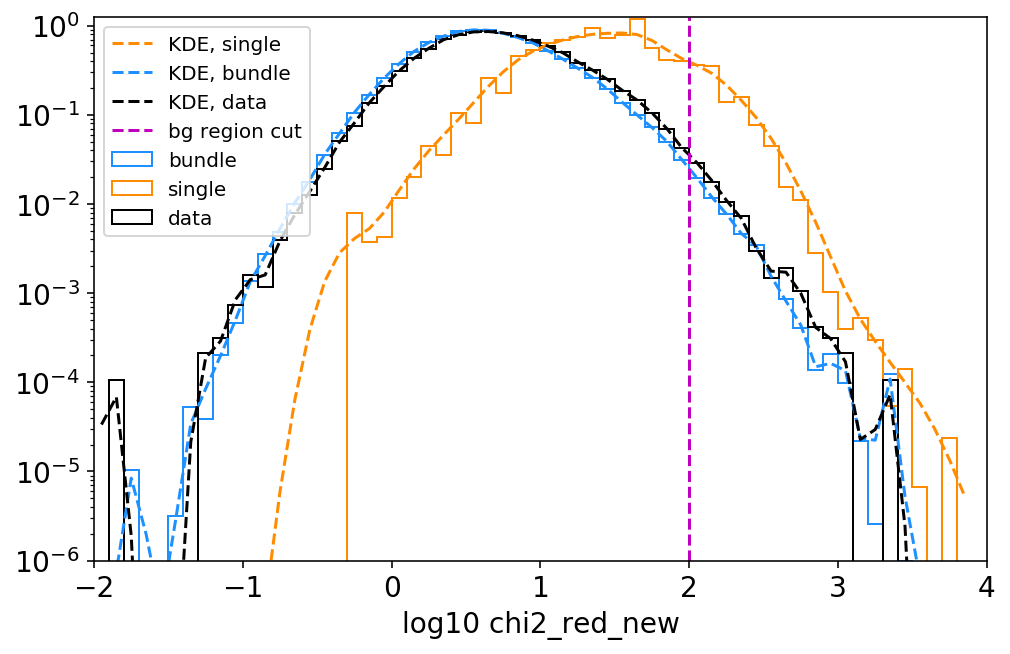

In [34]:
plt.figure(figsize=(8,5))

plt.hist(np.log10(chi2_red_new_corsika[cut_corsika])[singleness_corsika[cut_corsika]<bundle_threshold],histtype='step',weights=weight_corsika[cut_corsika][singleness_corsika[cut_corsika]<bundle_threshold],bins=bins,density=True,label='bundle',color='dodgerblue')
plt.hist(np.log10(chi2_red_new_corsika[cut_corsika])[singleness_corsika[cut_corsika]>single_threshold],histtype='step',weights=weight_corsika[cut_corsika][singleness_corsika[cut_corsika]>single_threshold],bins=bins,density=True,label='single',color='darkorange')
plt.hist(np.log10(chi2_red_new_data_burn[cut_data]),histtype='step',bins=bins,color='black',density=True,label='data')
plt.plot(bs,kde_single,label='KDE, single',ls='--',color='darkorange')
plt.plot(bs,kde_bundle,label='KDE, bundle',ls='--',color='dodgerblue')
plt.plot(bs,kde_data,label='KDE, data',ls='--',color='black')
plt.axvline(2,color='m',ls='--',label='bg region cut')

plt.legend(prop={'size':10},loc='upper left')
plt.xlim(-2,4)
plt.ylim(1e-6,)
plt.semilogy()
plt.xlabel('log10 chi2_red_new')
plt.show()

[0.926]


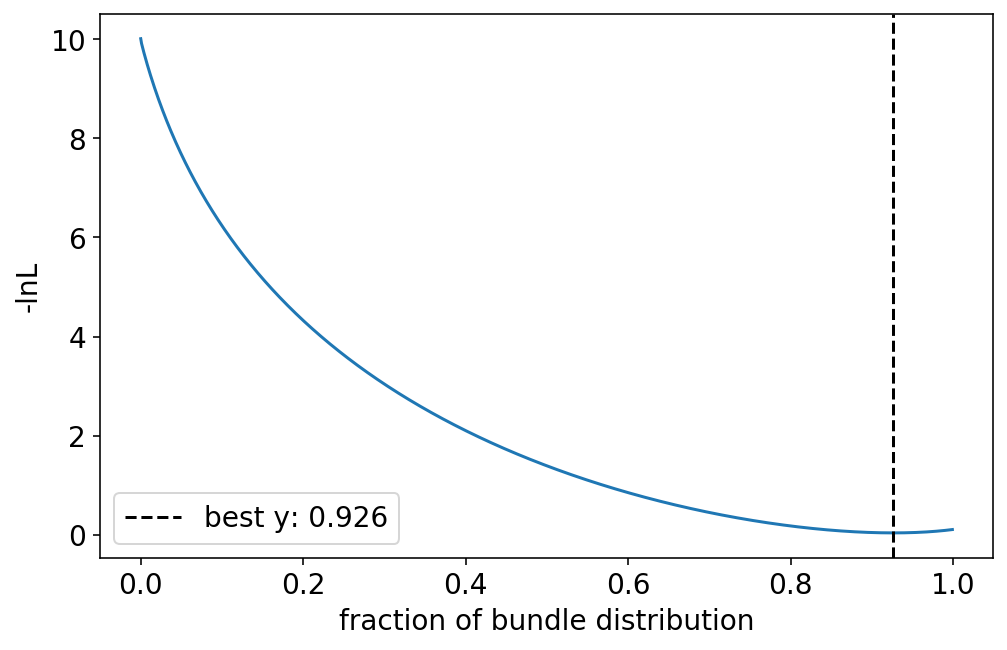

In [35]:
def llh(y):
    exp = y*kde_bundle + (1-y)*kde_single

    obs = kde_data
    cut = (exp>0) & (obs>0) & (bs < 2) # only use bg region
    exp = exp[cut]
    obs = obs[cut]

    lnL = np.log(exp)*obs - exp - (obs*np.log(obs) - obs)
    return - np.sum(lnL)

t = np.arange(0,1,0.001)
ls = []
for i in t:
    ls.append(llh(i))
ls = np.array(ls)
print(t[ls==np.min(ls)])
y_best = t[ls==np.min(ls)][0]

plt.figure(figsize=(8,5))
plt.plot(t,ls)
plt.axvline(y_best,ls='--',label='best y: '+str(np.round(y_best,3)),color='black')
plt.xlabel('fraction of bundle distribution')
plt.ylabel('-lnL')
plt.legend()
plt.show()

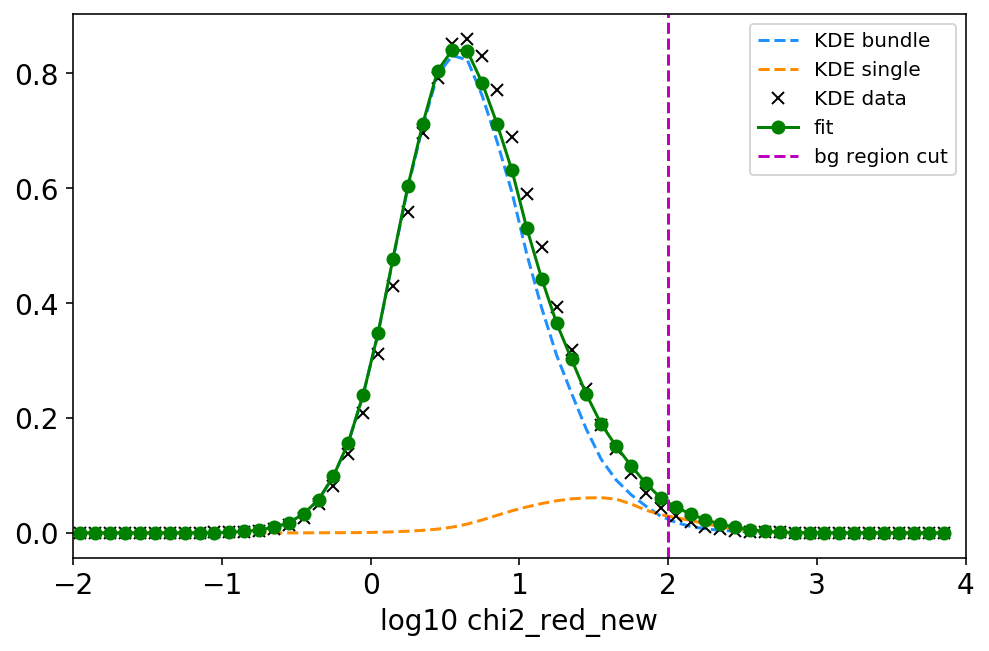

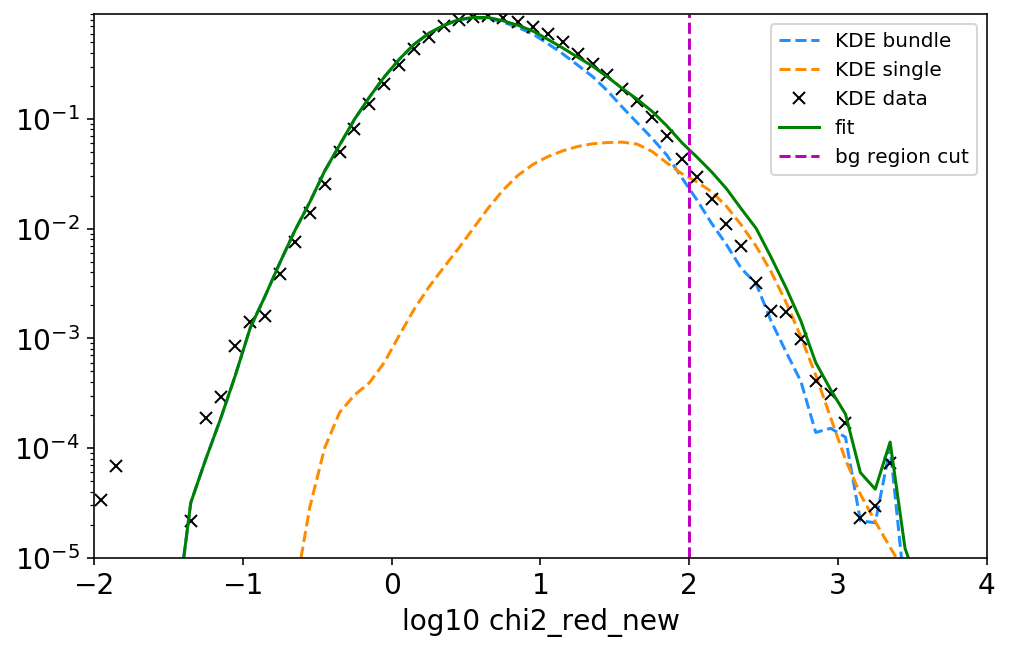

In [36]:
plt.figure(figsize=(8,5))
plt.plot(bs,kde_bundle*y_best,'--',label='KDE bundle',color='dodgerblue')
plt.plot(bs,kde_single*(1-y_best),'--',label='KDE single',color='darkorange')
plt.plot(bs,kde_data,'x',label='KDE data',color='black')
plt.plot(bs,kde_bundle*y_best+kde_single*(1-y_best),'o-',label='fit',color='green')
plt.axvline(2,color='m',ls='--',label='bg region cut')
plt.xlabel('log10 chi2_red_new')
plt.legend(prop={'size':10},loc='upper right')
plt.xlim(-2,4)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(bs,kde_bundle*y_best,'--',label='KDE bundle',color='dodgerblue')
plt.plot(bs,kde_single*(1-y_best),'--',label='KDE single',color='darkorange')
plt.plot(bs,kde_data,'x',label='KDE data',color='black')
plt.plot(bs,kde_bundle*y_best+kde_single*(1-y_best),label='fit',color='green')
plt.axvline(2,color='m',ls='--',label='bg region cut')
plt.xlabel('log10 chi2_red_new')
plt.xlim(-2,4)
plt.ylim(1e-5,)
plt.yscale('log')
plt.legend(prop={'size':10},loc='upper right')
plt.show()

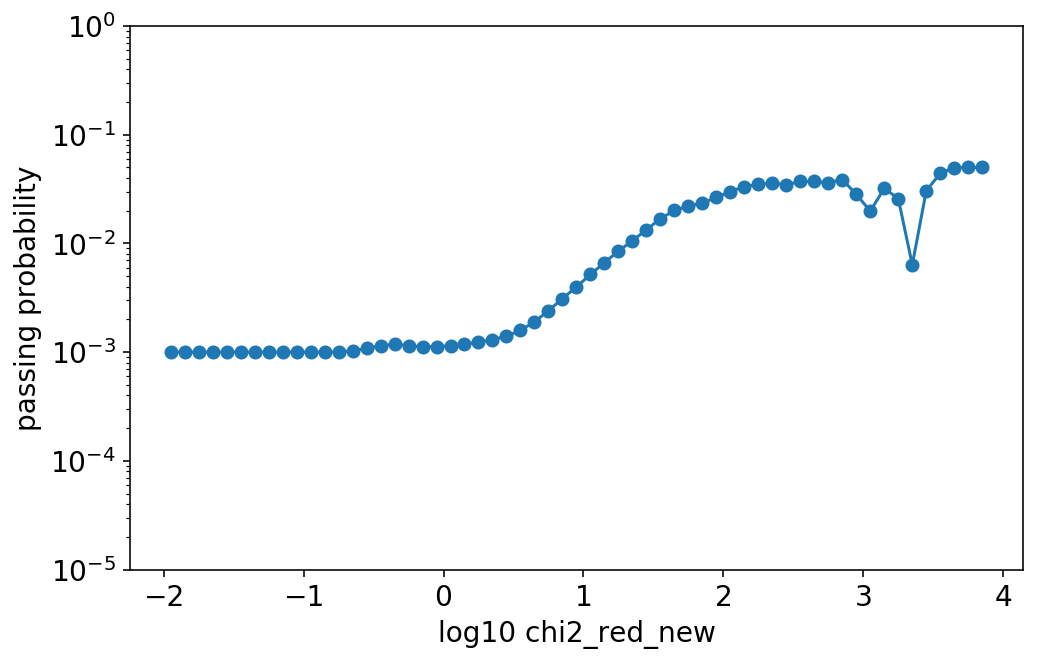

In [37]:
# estimate theoretical veto probability

plt.figure(figsize=(8,5))
#     h_sum = kde_bundle + kde_single
h_sum = y_best*kde_bundle + (1-y_best)*kde_single

p_passing = 1-(y_best*kde_bundle/h_sum*P_bundle + (1-y_best)*kde_single/h_sum*0.95)
# p_passing = 1-y_best*kde_bundle/h_sum#*(1-P_bundle) + (1-y_best)*kde_single/h_sum*(1-P_single)
# p_passing[p_passing<1e-3]=1e-3
# print(y_best*kde_bundle/h_sum*P_bundle,(1-y_best)*kde_single/h_sum*P_single,p_passing)
# print(y_best*kde_bundle/h_sum)
plt.plot(bs, p_passing,'o-')
plt.semilogy()
plt.ylim(1e-5,1)
plt.xlabel('log10 chi2_red_new')
plt.ylabel('passing probability')
plt.show()

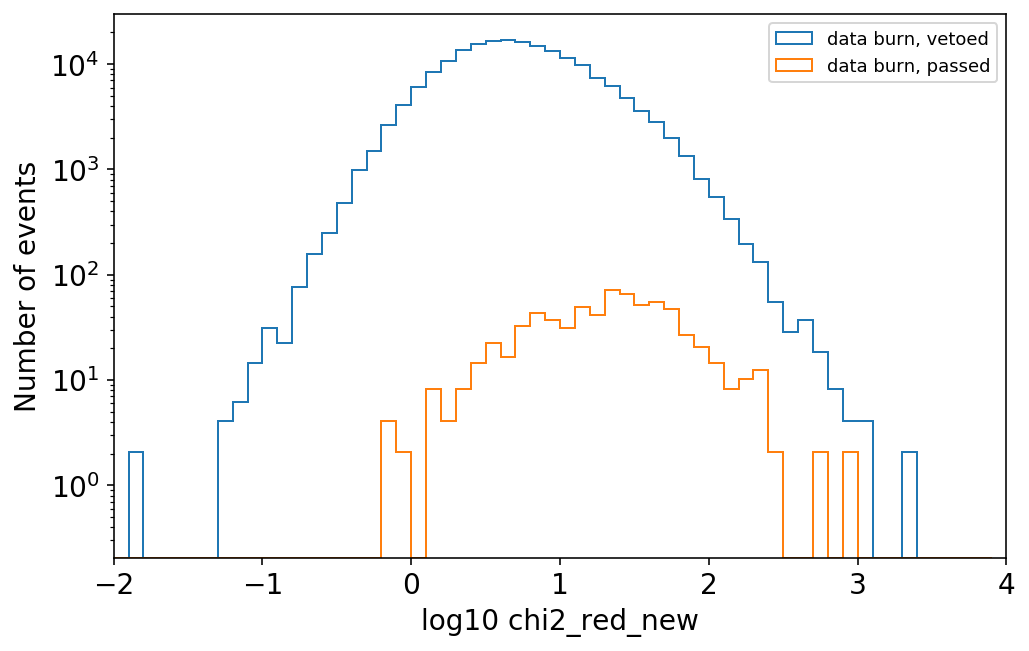

In [38]:
plt.figure(figsize=(8,5))
h_veto,b_,p_ = plt.hist(np.log10(chi2_red_new_data_burn[cut_data])[vetoed_2_data_burn[cut_data]],bins=bins,histtype='step',weights=weight_data_burn[cut_data][vetoed_2_data_burn[cut_data]],label='data burn, vetoed',log=True)
h_pass,b_,p_ = plt.hist(np.log10(chi2_red_new_data_burn[cut_data])[passed_2_data_burn[cut_data]],bins=bins,histtype='step',weights=weight_data_burn[cut_data][passed_2_data_burn[cut_data]],label='data burn, passed',log=True)
plt.xlabel('log10 chi2_red_new')
plt.ylabel('Number of events')
plt.legend(prop={'size':9})
plt.xlim(-2,4)
plt.show()

[0.955]


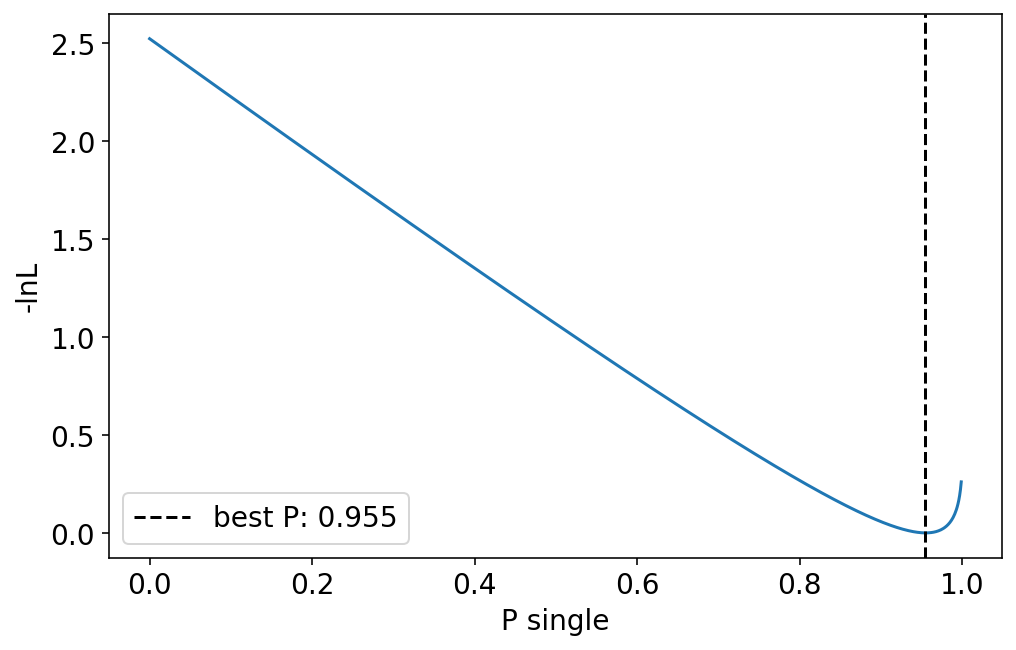

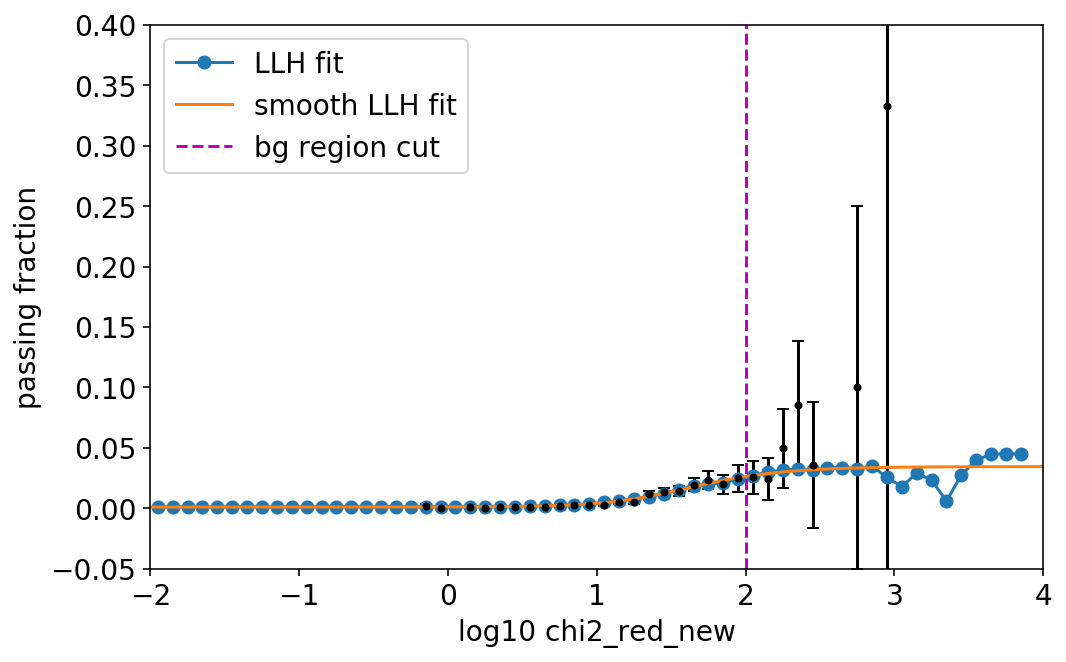

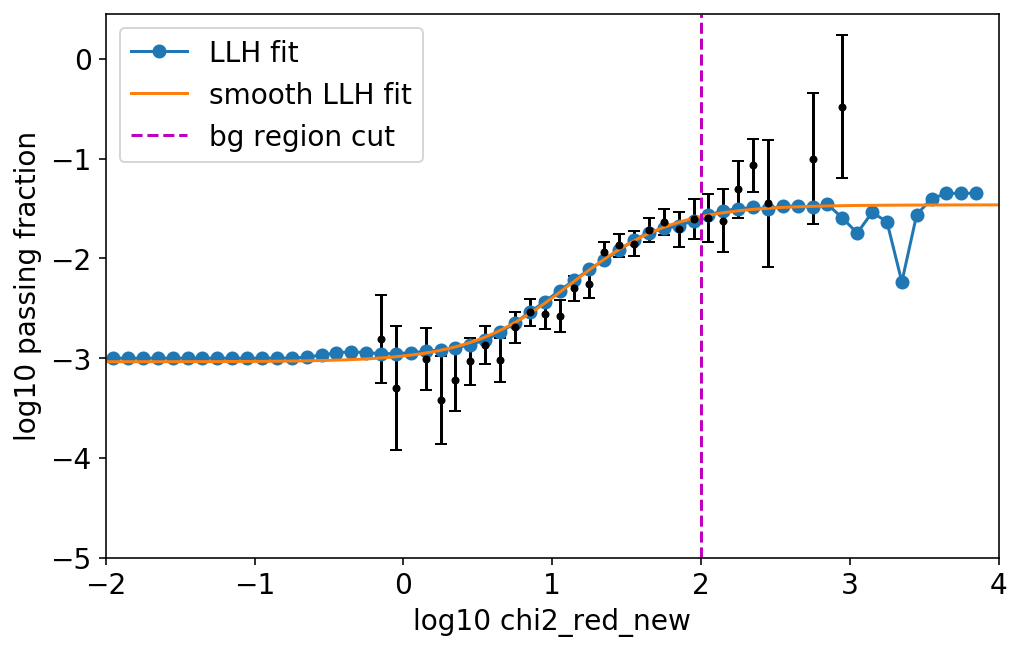

In [49]:
def sigma(x,y): # x/y
    return weight_data_burn[0]*x/y * np.sqrt(1/x + 1/y)
def sigma_log10(x,y): # log10(x/y)
    return weight_data_burn[0]/np.log(10) * np.sqrt(1/x + 1/y)

h_tot,b_ = np.histogram(np.log10(chi2_red_new_data_burn[cut_data]),bins=bins,weights=weight_data_burn[cut_data]) 
h_veto,b_ = np.histogram(np.log10(chi2_red_new_data_burn[cut_data])[vetoed_2_data_burn[cut_data]],bins=bins,weights=weight_data_burn[cut_data][vetoed_2_data_burn[cut_data]]) 
h_pass,b_ = np.histogram(np.log10(chi2_red_new_data_burn[cut_data])[passed_2_data_burn[cut_data]],bins=bins,weights=weight_data_burn[cut_data][passed_2_data_burn[cut_data]]) 

cut_nonzero = (h_pass>0)
b_ = (b_[1:]+b_[:-1])/2
b_=b_[cut_nonzero]
h_veto=h_veto[cut_nonzero]
h_tot=h_tot[cut_nonzero]
h_pass=h_pass[cut_nonzero]
pass_ratio = h_pass/h_tot
err_pass = sigma(h_pass,h_tot)
err_pass_log10 = sigma_log10(h_pass,h_tot)

# --- likelihood fit to find best P_single --- # 

def llh(Ps):
    exp = ( 1-(y_best*kde_bundle/h_sum*P_bundle + (1-y_best)*kde_single/h_sum*Ps) )[cut_nonzero]
    obs = pass_ratio 
    bs_nonzero = bs[cut_nonzero]
    
    cut = (bs_nonzero < 2) # only use bg region;
    exp = exp[cut]
    obs = obs[cut]

    lnL = np.log(exp)*obs - exp - (obs*np.log(obs) - obs)
    return - np.sum(lnL)


t = np.arange(0,1,0.001)
ls = []
for i in t:
    ls.append(llh(i))
ls = np.array(ls)
print(t[ls==np.min(ls)])
P_best = t[ls==np.min(ls)][0]

plt.figure(figsize=(8,5))
plt.plot(t,ls)
plt.axvline(P_best,ls='--',label='best P: '+str(np.round(P_best,3)),color='black')
plt.xlabel('P single')
plt.ylabel('-lnL')
plt.legend()
plt.show()

p_passing_best = ( 1-(y_best*kde_bundle/h_sum*P_bundle + (1-y_best)*kde_single/h_sum*P_best) )

def fp(s,a,b,c,d):
    return a*np.tanh(d*(s-b))+c
popt,pcov = curve_fit(fp,bs[(bs>0)&(bs<2.5)],np.log10(p_passing_best)[(bs>0)&(bs<2.5)])

# --- end llh fitting --- # 

plt.figure(figsize=(8,5))
t = np.arange(-2,4,0.01)
plt.errorbar(b_,pass_ratio,fmt='.',yerr=err_pass,capsize=3,color='black')
plt.plot(bs, p_passing_best,'o-',label='LLH fit')
plt.plot(t,10**fp(t,*popt),label='smooth LLH fit')
plt.axvline(2,color='m',ls='--',label='bg region cut')
plt.xlim(-2,4)
plt.ylim(-0.05,0.4)
plt.xlabel('log10 chi2_red_new')
plt.ylabel('passing fraction')
plt.legend()

plt.figure(figsize=(8,5))
t = np.arange(-2,4,0.01)
plt.errorbar(b_,np.log10(pass_ratio),fmt='.',yerr=err_pass_log10,capsize=3,color='black')
plt.plot(bs, np.log10(p_passing_best),'o-',label='LLH fit')
plt.plot(t,fp(t,*popt),label='smooth LLH fit')
plt.axvline(2,color='m',ls='--',label='bg region cut')
plt.xlim(-2,4)
plt.ylim(-5,)
# plt.ylim(np.min(np.log10(pass_ratio)[np.isfinite(np.log10(pass_ratio))]),np.max(np.log10(pass_ratio)[np.isfinite(np.log10(pass_ratio))]))
plt.xlabel('log10 chi2_red_new')
plt.ylabel('log10 passing fraction')
plt.legend()

plt.show()

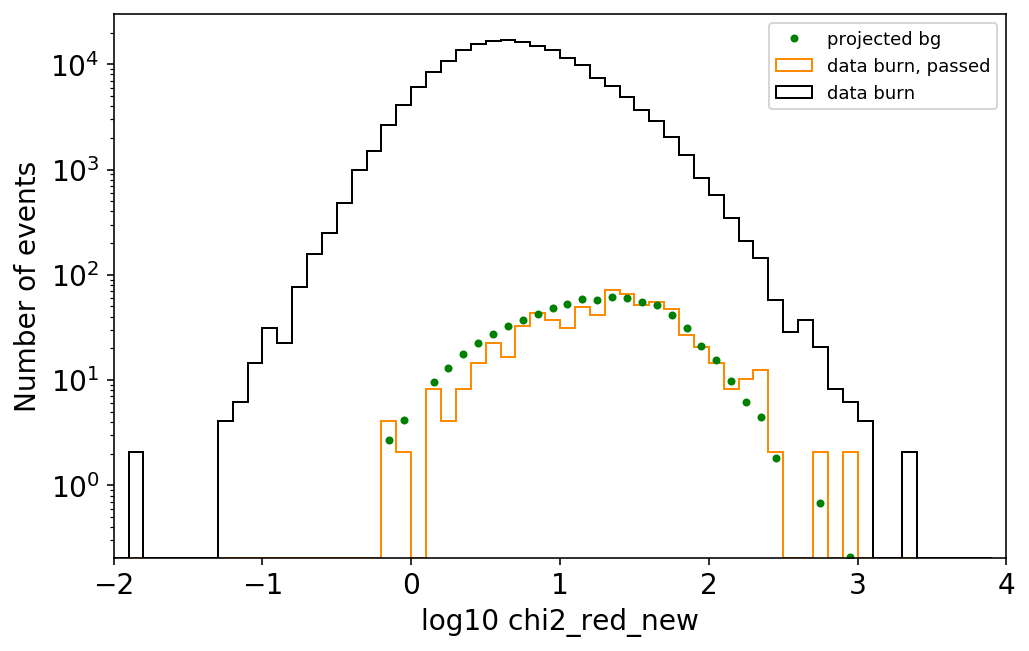

In [41]:
plt.figure(figsize=(8,5))
plt.hist(np.log10(chi2_red_new_data_burn[cut_data])[passed_2_data_burn[cut_data]],bins=bins,histtype='step',weights=weight_data_burn[cut_data][passed_2_data_burn[cut_data]],label='data burn, passed',log=True,color='darkorange')
plt.hist(np.log10(chi2_red_new_data_burn[cut_data]),bins=bins,histtype='step',weights=weight_data_burn[cut_data],label='data burn',log=True,color='black')    

# do projection

# plt.plot(b_,h_pass,'.')
h_proj = h_tot * 10**fp(b_,*popt)
plt.plot(b_,h_proj,'.',color='green',label='projected bg')

plt.xlabel('log10 chi2_red_new')
plt.ylabel('Number of events')
plt.legend(prop={'size':9})
plt.xlim(-2,4)
plt.show()

In [42]:
sigs = []
sb_ratios = []
for i in b_:
    bg = np.sum(h_proj[b_>i])
    obs = np.sum(h_pass[b_>i])
    sig = obs - bg
    sb_ratio = sig/bg

    sigs=np.append(sigs, sig)
    sb_ratios=np.append(sb_ratios, sb_ratio)

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


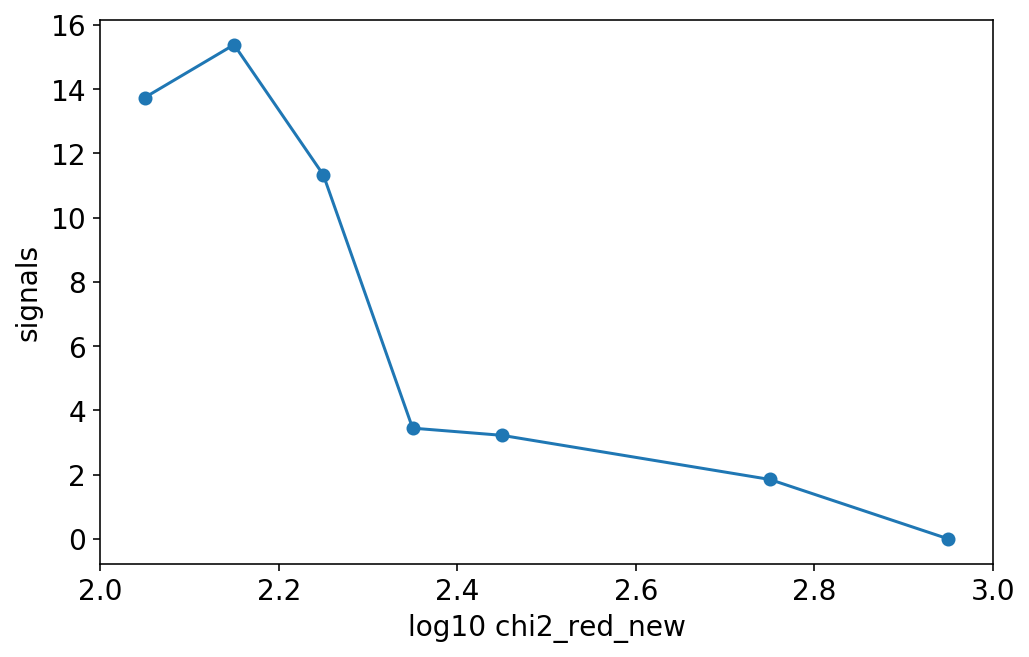

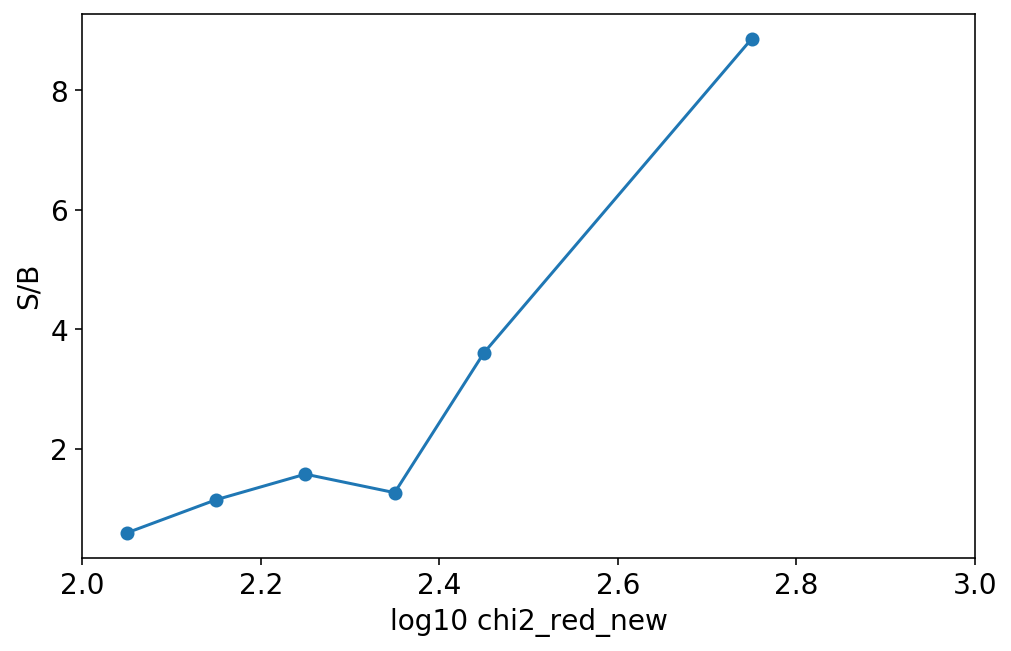

In [43]:
plt.figure(figsize=(8,5))
plt.plot(b_[b_>2],sigs[b_>2],'o-')
plt.xlabel('log10 chi2_red_new')
plt.ylabel('signals')
plt.xlim(2,3)

plt.figure(figsize=(8,5))
plt.plot(b_[b_>2],sb_ratios[b_>2],'o-')
plt.xlabel('log10 chi2_red_new')
plt.ylabel('S/B')
plt.xlim(2,3)
plt.show()

In [50]:
print(*eventid_data_burn[(ineff_data_burn<0.01)&(passed_2_data_burn)&(np.log10(chi2_red_new_data_burn)>2.4)])
print(*runid_data_burn[(ineff_data_burn<0.01)&(passed_2_data_burn)&(np.log10(chi2_red_new_data_burn)>2.4)])

70838028 74812129 46102602
122675 128781 133811


# try Global Optimization

In [45]:
def fitting(INEFF):
    plt.figure(figsize=(8,5))
    bins = np.arange(-2,4,0.1)
    bundle_threshold = 0.8 # bundle: singleness < bundle_threshold
    single_threshold = 0.8 # single: singleness > single_threshold
    
    cut_corsika = (ineff_corsika<INEFF)
    cut_data = (ineff_data_burn<INEFF)
    h_bundle,b,_=plt.hist(np.log10(chi2_red_new_corsika[cut_corsika])[singleness_corsika[cut_corsika]<bundle_threshold],histtype='step',weights=weight_corsika[cut_corsika][singleness_corsika[cut_corsika]<bundle_threshold],bins=bins,density=True,label='bundle',color='dodgerblue')
    h_single,b,_=plt.hist(np.log10(chi2_red_new_corsika[cut_corsika])[singleness_corsika[cut_corsika]>single_threshold],histtype='step',weights=weight_corsika[cut_corsika][singleness_corsika[cut_corsika]>single_threshold],bins=bins,density=True,label='single',color='darkorange')
    h_data,b,_=plt.hist(np.log10(chi2_red_new_data_burn[cut_data]),histtype='step',bins=bins,color='black',density=True,label='data')
    plt.legend()
    plt.xlim(-2,4)
    plt.xlabel('log10 chi2_red_new')
    plt.show()
    
    bs = (b[1:]+b[:-1])/2
    def llh(y):
        exp = y*h_bundle + (1-y)*h_single
        obs = h_data
        cut = (exp>0) & (obs>0)
    #     print(exp,obs)
        exp = exp[cut]
        obs = obs[cut]

        lnL = np.log(exp)*obs - exp - (obs*np.log(obs) - obs)
        return - np.sum(lnL)

    t = np.arange(0,1,0.001)
    ls = []
    for i in t:
        ls.append(llh(i))
    ls = np.array(ls)
    print(t[ls==np.min(ls)])
    y_best = t[ls==np.min(ls)][0]
    
    plt.figure(figsize=(8,5))
    plt.plot(t,ls)
    plt.axvline(y_best,ls='--',label='best y: '+str(np.round(y_best,3)),color='black')
    plt.xlabel('fraction of bundle distribution')
    plt.ylabel('-lnL')
    plt.legend()

    plt.figure(figsize=(8,5))
    plt.plot(bs,h_bundle*y_best,'--',label='bundle',color='dodgerblue')
    plt.plot(bs,h_single*(1-y_best),'--',label='single',color='darkorange')
    plt.plot(bs,h_data,'x',label='data',color='black')
    plt.plot(bs,h_bundle*y_best+h_single*(1-y_best),'o-',label='fit',color='green')
    plt.xlabel('log10 chi2_red_new')
    plt.legend(loc='upper right')
    plt.xlim(-2,4)
    plt.show()

    plt.figure(figsize=(8,5))
    plt.plot(bs,h_bundle*y_best,'--',label='bundle',color='dodgerblue')
    plt.plot(bs,h_single*(1-y_best),'--',label='single',color='darkorange')
    plt.plot(bs,h_data,'x',label='data',color='black')
    plt.plot(bs,h_bundle*y_best+h_single*(1-y_best),label='fit',color='green')
    plt.xlabel('log10 chi2_red_new')
    plt.xlim(-2,4)
    plt.ylim(1e-5,)
    plt.yscale('log')
    plt.legend(loc='upper right')
    
    # calculate theoretical veto probability
    plt.figure(figsize=(8,5))
#     h_tot = h_bundle + h_single
    h_tot = y_best * h_bundle + (1-y_best)*h_single

    p_passing = 1-(y_best*h_bundle/h_tot*P_bundle + (1-y_best)*h_single/h_tot*P_single)

    plt.plot(bs, p_passing)
    plt.xlabel('log10 chi2_red_new')
    plt.ylabel('passing probability')
    
    def sigma(x,y): # x/y
        return weight_data_burn[0]*x/y * np.sqrt(1/x + 1/y)
    def sigma_log10(x,y): # log10(x/y)
        return weight_data_burn[0]/np.log(10) * np.sqrt(1/x + 1/y)

    plt.figure(figsize=(8,5))
    h_veto,b_,p_ = plt.hist(np.log10(chi2_red_new_data_burn[cut_data])[vetoed_2_data_burn[cut_data]],bins=bins,histtype='step',weights=weight_data_burn[cut_data][vetoed_2_data_burn[cut_data]],label='data burn, vetoed',log=True)
    h_pass,b_,p_ = plt.hist(np.log10(chi2_red_new_data_burn[cut_data])[passed_2_data_burn[cut_data]],bins=bins,histtype='step',weights=weight_data_burn[cut_data][passed_2_data_burn[cut_data]],label='data burn, passed',log=True)
    plt.xlabel('log10 chi2_red_new')
    plt.ylabel('Number of events')
    plt.legend(prop={'size':9})
    plt.xlim(-2,4)


    h_tot,b_ = np.histogram(np.log10(chi2_red_new_data_burn[cut_data]),bins=bins,weights=weight_data_burn[cut_data]) 
    h_veto,b_ = np.histogram(np.log10(chi2_red_new_data_burn[cut_data])[vetoed_2_data_burn[cut_data]],bins=bins,weights=weight_data_burn[cut_data][vetoed_2_data_burn[cut_data]]) 
    h_pass,b_ = np.histogram(np.log10(chi2_red_new_data_burn[cut_data])[passed_2_data_burn[cut_data]],bins=bins,weights=weight_data_burn[cut_data][passed_2_data_burn[cut_data]]) 

    b_ = (b_[1:]+b_[:-1])/2
    b_=b_[h_pass>0]
    h_veto=h_veto[h_pass>0]
    h_tot=h_tot[h_pass>0]
    h_pass=h_pass[h_pass>0]
    pass_ratio = h_pass/h_tot
    veto_ratio = h_veto/h_tot
    sig_pass = sigma(h_pass,h_tot)
    sig_pass_log10 = sigma_log10(h_pass,h_tot)
    sig_veto = sigma(h_veto,h_tot)
    pv_ratio = h_pass/h_veto
    sig_vp = sigma(h_pass,h_veto)
    sig_vp_log10 = sigma_log10(h_pass,h_veto)
    
    plt.figure(figsize=(8,5))
    t = np.arange(-2,4,0.01)
    plt.errorbar(b_,pass_ratio,fmt='.',yerr=sig_pass,capsize=3,color='black')
    plt.xlim(-2,4)
    plt.ylim(-0.05,0.4)
    plt.xlabel('log10 chi2_red_new')
    plt.ylabel('passing fraction')

    plt.figure(figsize=(8,5))
    t = np.arange(-2,4,0.01)
    plt.errorbar(b_,np.log10(pass_ratio),fmt='.',yerr=sig_pass_log10,capsize=3,color='black')
    plt.xlim(-2,4)
    plt.ylim(np.min(np.log10(pass_ratio)[np.isfinite(np.log10(pass_ratio))]),np.max(np.log10(pass_ratio)[np.isfinite(np.log10(pass_ratio))]))
    plt.xlabel('log10 chi2_red_new')
    plt.ylabel('log10 passing fraction')

    
    plt.show()

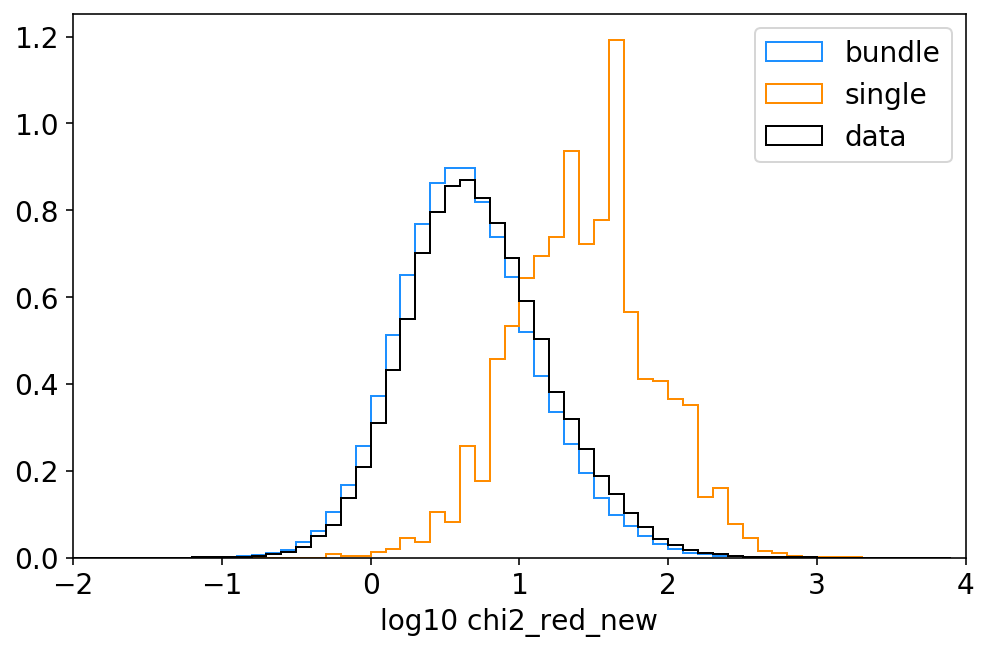

[0.946]


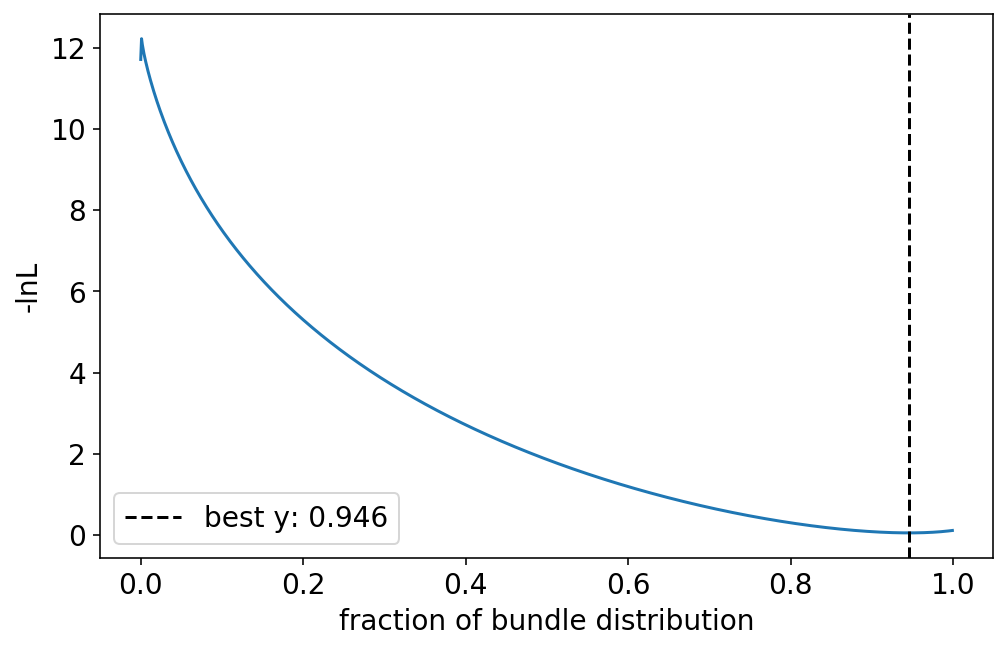

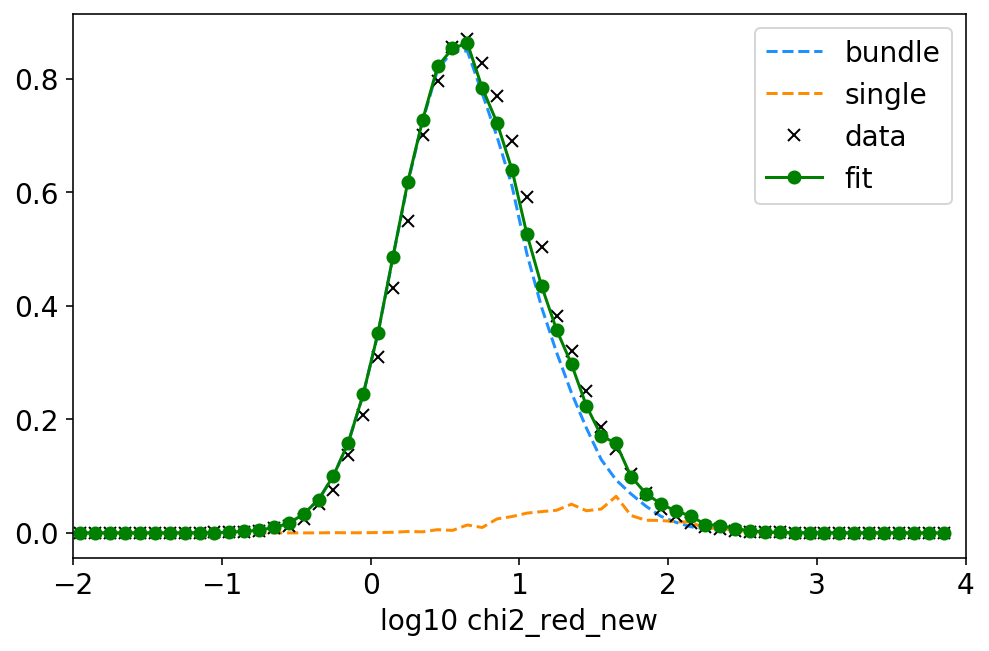

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide


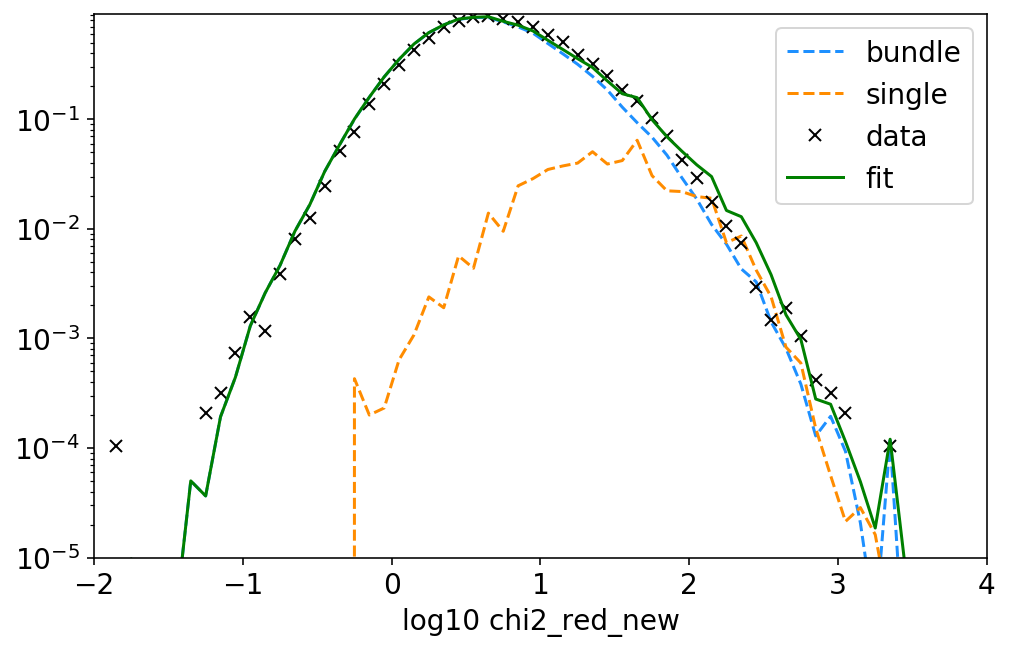

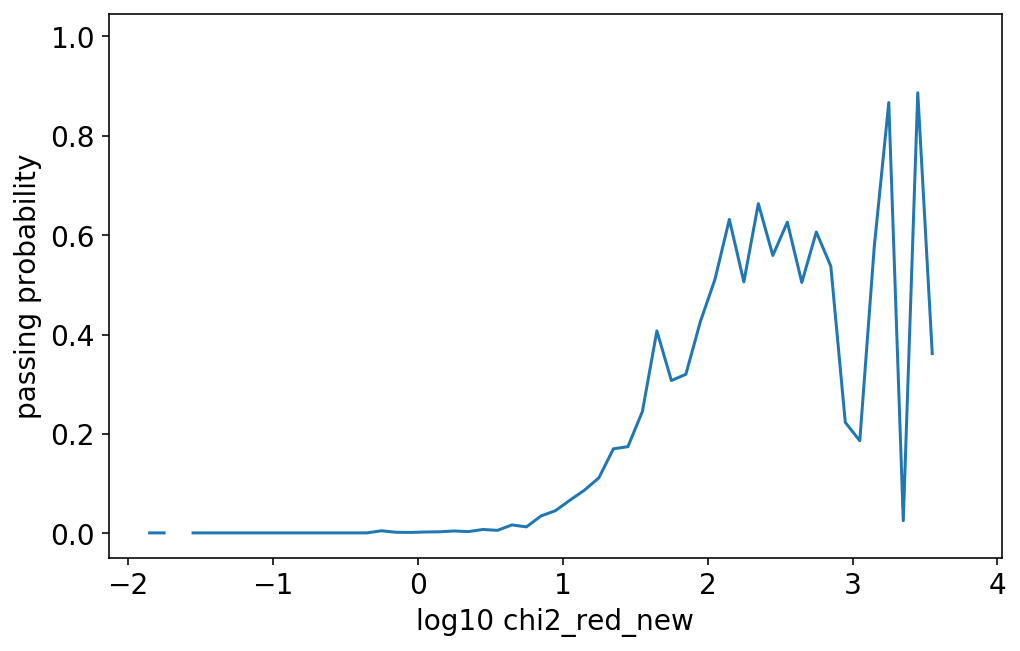

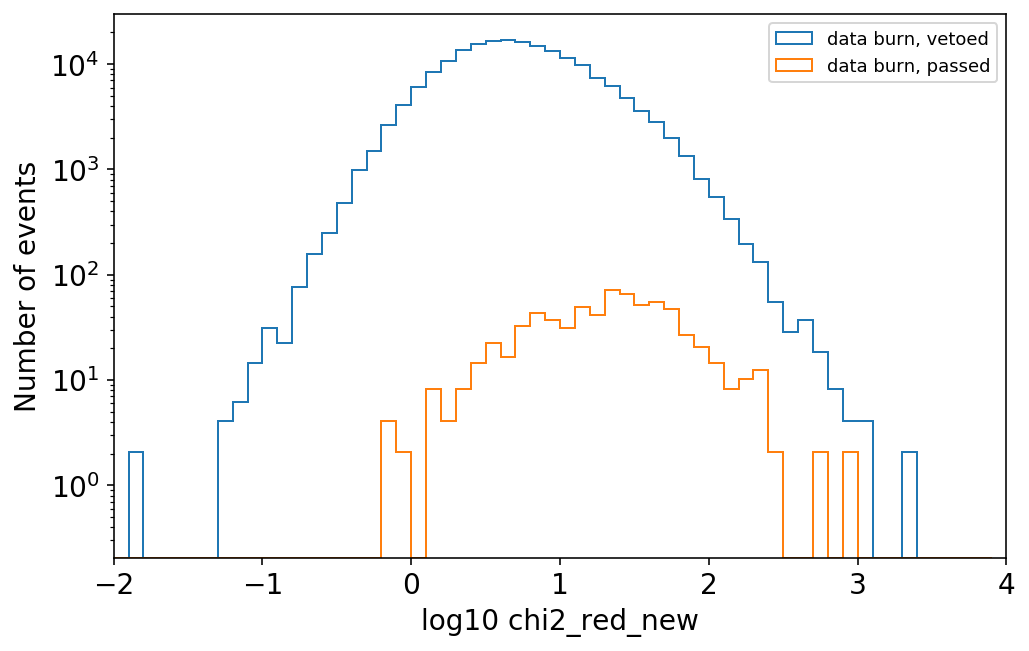

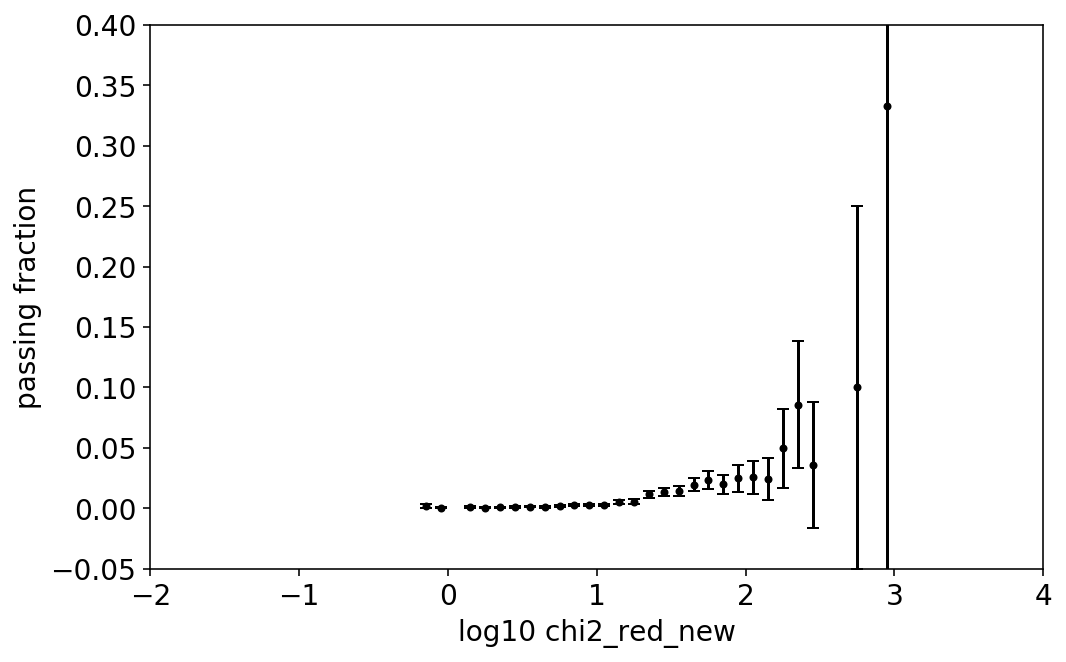

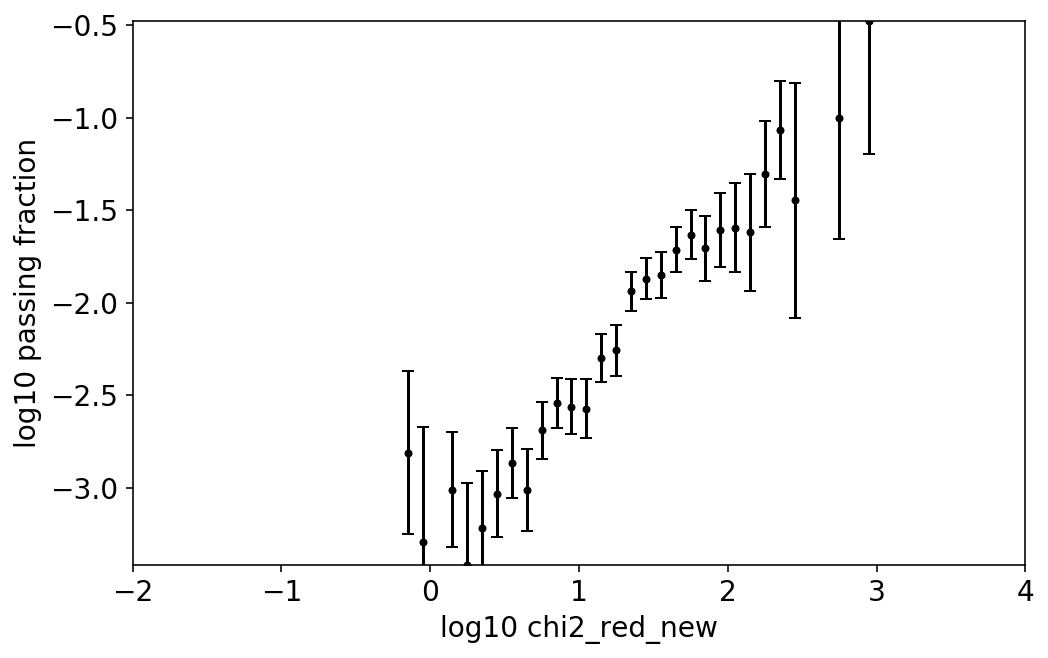

In [46]:
fitting(0.01)

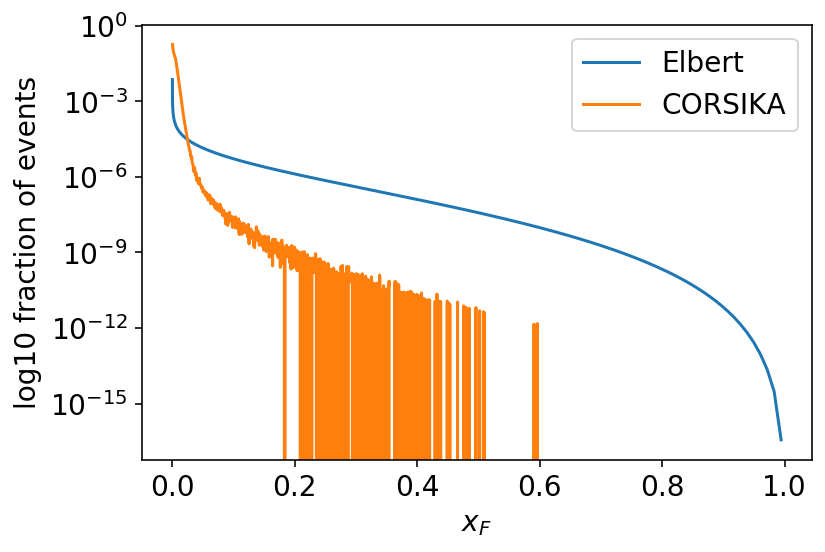

In [47]:
# using CORSIKA 
def Elbert(x,A,cos_zenith):
    Kl = 49.5
    p1 = 0.625
    p2 = 4.94
    p3 = 0.58

    return Kl*A/(1000*cos_zenith) * x**(-p1) * (1-x**p3)**p2

Xf = E_bundle_corsika/prim_e_corsika

A_corsika[A_corsika == 2212] = 1
A_corsika[A_corsika == 1000020040] = 4
A_corsika[A_corsika == 1000070140] = 14   
A_corsika[A_corsika == 1000130270] = 27   
A_corsika[A_corsika == 1000260560] = 56  

Nl = Elbert(Xf,A_corsika,np.cos(zenith_corsika))

H, edges = np.histogramdd(np.c_[Xf,
                                A_corsika,
                                np.cos(zenith_corsika)],
                          bins=1000,weights=Nl)

x = np.linspace(0,0.6,1000)
xs_corsika = []
ns_corsika = []
for i in range(0,len(x)-1):
    xs_corsika.append((x[i]+x[i+1])/2)
    ns_corsika.append(np.sum(H[i,:,:]))
    
plt.semilogy(xs[np.isfinite(ns)],ns[np.isfinite(ns)]/np.sum(ns[np.isfinite(ns)]),label='Elbert')
plt.semilogy(xs_corsika,ns_corsika/np.sum(ns_corsika),label='CORSIKA')

plt.legend()
plt.xlabel(r'$x_F$')
plt.ylabel('log10 fraction of events')
plt.show()

In [48]:
def sampling():
    

SyntaxError: unexpected EOF while parsing (<ipython-input-48-8998f7a029e7>, line 2)

In [52]:
with tables.open_file(data_dir+'data_h5/data_burn.h5','r') as f:
# with tables.open_file(data_dir+'data_h5/data_burn_new.h5','r') as f: # 8 years
    nfile_data = [2831731.134,3081951.304,3158084.037,3155703.188,3082765.564]

    runid_data_burn = f.root.I3EventHeader.cols.Run[:]
    eventid_data_burn = f.root.I3EventHeader.cols.Event[:]

    weight_data_burn = lifetime/np.sum(nfile_data) * np.ones(len(zenith_data_burn))


In [58]:
print(np.sum((eventid_data_burn==46102602)&(runid_data_burn==133811)))
print(np.sum((eventid_data_burn==50877282)&(runid_data_burn==128192)))
print(np.sum((eventid_data_burn==74812129)&(runid_data_burn==128781)))

0
1
1


In [ ]:
 46102602
 133811